In [259]:
import pandas as pd
import seaborn as sns
import pandas_gbq
import tqdm
from google.oauth2 import service_account
import matplotlib.pyplot as plt

In [260]:
credentials = service_account.Credentials.from_service_account_file(
    'trumid-case-8a70bafcd63d.json',
)
pandas_gbq.context.credentials = credentials
# Update the in-memory credentials cache (added in pandas-gbq 0.7.0).
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "trumid-case"

In [261]:
%matplotlib inline
sns.set_theme(style="whitegrid")

# Question 1: 

Assess the profitability of each product category. Are there significant differences between
them? If so, what might TheLook consider changing about its product mix to increase margins
overall?

## Data Exploration

 *  In `products`, are both `ID` and `sku` unique? **Yes**
 *  Does every item in `inventory_items` have a corresponding record in `products`? **Yes**
 *  Does the `cost` in `products` always match the cost in `inventory items`? **Yes**
 *  Does the `sale price` in `products` always match the `retail price` in `order items`? **Yes** <- So no sales?
 *  How often are items sold at below list price? (i.e. at a discount?) <- **Never! See above**
 *  Does every item in `order_items` have a corresponding record in `products`? **Yes**
 *  Does every item in `inventory_items` have a corresponding record in `order_items`?
 *  Does every item in `order_items` have a corresponding record in `inventory_items`?


In [4]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT id) as unique_ids
    , count(distinct sku) unique_skus
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,unique_ids,unique_skus
0,29120,29120


In [5]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT CONCAT(id,'-',sku)) as unique_ids
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,unique_ids
0,29120


In [6]:
# Is the product cost ever different from the inventory cost?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_cost AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_products.cost as product_cost
   ,thelook_inventory_items.inventory_id
   ,thelook_inventory_items.cost as inventory_cost
FROM
    thelook_products
INNER JOIN
    thelook_inventory_items
ON
    thelook_products.product_id = thelook_inventory_items.product_id
AND
    thelook_products.sku = thelook_inventory_items.product_sku
)
SELECT
    COUNT(*) AS count_cost_difference
FROM
    thelook_cost
WHERE
    product_cost != inventory_cost
"""
product_cost = pandas_gbq.read_gbq(query)
product_cost

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,count_cost_difference
0,0


In [7]:
# Is the order item sale ever different from the product list price?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_revenue AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_orderitems.order_item_id
   ,thelook_products.retail_price
   ,thelook_orderitems.sale_price
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    *
FROM
    thelook_revenue
WHERE
    retail_price != sale_price
"""
product_revenue = pandas_gbq.read_gbq(query)
product_revenue

Downloading: |                                                                                                                                                                                             |


,product_id,sku,order_item_id,retail_price,sale_price


In [8]:
# Is the order item sale ever different from the product list price?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,inventory_item_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_item_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_inventory_order AS (
SELECT
    thelook_inventory_items.inventory_item_id
    ,thelook_orderitems.order_item_id
FROM
    thelook_inventory_items
LEFT JOIN
    thelook_orderitems
ON
    thelook_inventory_items.inventory_item_id = thelook_orderitems.inventory_item_id
)
SELECT
    COUNT(*) AS num_inventory_items
    ,COUNT(CASE WHEN order_item_id IS NOT NULL THEN inventory_item_id ELSE NULL END) AS num_inventory_items_ordered
FROM
    thelook_inventory_order
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_inventory_items,num_inventory_items_ordered
0,489627,181170


## Analyzing Shelf Life

 *  What is the order workflow?
 *  What fields should be relied on to understand status? **Can't use `is_sold`, cases exist where something is delivered but is_sold IS NULL, normally would ask engineering or product about it but will use order_items.created_at instead**
 *  How long does it take to turnover inventory? **Can't really estimate because of data quality issues**
 *  How much of inventory is unsold?

In [9]:
# TODO: Layer in order status and returned date so we can exclude cancelled or returned from metrics
# Calculate average, median, min, max time to sell and ratio of sold to unsold
inventory_sql = """
WITH thelook_order_item_details AS (
SELECT
    inventory_items.product_category
    ,order_items.id AS order_item_id
    ,inventory_items.id AS inventory_item_id 
    ,order_items.user_id
    ,order_items.product_id
    ,order_items.sale_price AS item_sale_price
    ,inventory_items.cost AS item_cost
    ,inventory_items.sold_at
    ,CASE WHEN order_items.id IS NOT NULL THEN order_items.sale_price - inventory_items.cost ELSE NULL END AS item_profit
    ,inventory_items.created_at AS inventory_item_logged_at
    ,order_items.created_at AS order_item_placed_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.returned_at AS order_item_returned_at
    ,orders.created_at AS order_placed_at
    ,order_items.status
    ,CASE WHEN order_items.created_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_sold
    ,CASE WHEN order_items.returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS was_returned
FROM
    `trumid-case.thelook_ecommerce.inventory_items`  AS inventory_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items`  AS order_items
ON
    inventory_items.id = order_items.inventory_item_id
AND
    inventory_items.product_id = order_items.product_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders`  AS orders
ON
    order_items.order_id = orders.order_id
),
thelook_item_metrics AS (
SELECT
    product_category
    ,order_item_id
    ,inventory_item_id
    ,inventory_item_logged_at
    ,order_item_shipped_at
    ,order_placed_at
    ,sold_at
    ,status
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN item_profit
        ELSE 0 END AS realized_item_profit
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN DATE_DIFF(order_item_placed_at,inventory_item_logged_at,DAY) 
        ELSE NULL END AS days_to_turnover
FROM
    thelook_order_item_details
)
SELECT
    *
FROM 
    thelook_item_metrics
WHERE
    sold_at IS NOT NULL
"""
inventory_metrics = pandas_gbq.read_gbq(inventory_sql)

## This shows that there's weirdness in how the IDs were generated. This dataset has ID integrity but it doesn't actually make sense when you join them.
## For the purposes of this exercise will use inventory_id on its own and ignore the status

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
inventory_metrics

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover
0,Clothing Sets,<NA>,15553,2022-01-06 15:06:10+00:00,NaT,NaT,2022-01-26 03:20:10+00:00,None,0.0,<NA>
1,Clothing Sets,<NA>,102782,2023-01-24 10:42:40+00:00,NaT,NaT,2023-03-21 10:58:40+00:00,None,0.0,<NA>
2,Clothing Sets,<NA>,259689,2023-01-18 23:59:26+00:00,NaT,NaT,2023-02-18 10:32:26+00:00,None,0.0,<NA>
3,Clothing Sets,<NA>,341325,2023-08-01 18:32:05+00:00,NaT,NaT,2023-09-26 02:11:05+00:00,None,0.0,<NA>
4,Clothing Sets,<NA>,368707,2020-04-07 02:04:44+00:00,NaT,NaT,2020-05-25 14:18:44+00:00,None,0.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
181165,Fashion Hoodies & Sweatshirts,<NA>,265524,2023-05-14 09:44:41+00:00,NaT,NaT,2023-05-16 12:49:41+00:00,None,0.0,<NA>
181166,Fashion Hoodies & Sweatshirts,<NA>,288236,2023-01-01 20:56:11+00:00,NaT,NaT,2023-02-28 13:18:11+00:00,None,0.0,<NA>
181167,Fashion Hoodies & Sweatshirts,<NA>,296993,2022-08-22 21:22:22+00:00,NaT,NaT,2022-10-07 02:17:22+00:00,None,0.0,<NA>
181168,Fashion Hoodies & Sweatshirts,<NA>,451105,2023-10-01 16:35:51.076328+00:00,NaT,NaT,2023-11-12 17:57:51.076328+00:00,None,0.0,<NA>


In [11]:
inventory_metrics

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover
0,Clothing Sets,<NA>,15553,2022-01-06 15:06:10+00:00,NaT,NaT,2022-01-26 03:20:10+00:00,None,0.0,<NA>
1,Clothing Sets,<NA>,102782,2023-01-24 10:42:40+00:00,NaT,NaT,2023-03-21 10:58:40+00:00,None,0.0,<NA>
2,Clothing Sets,<NA>,259689,2023-01-18 23:59:26+00:00,NaT,NaT,2023-02-18 10:32:26+00:00,None,0.0,<NA>
3,Clothing Sets,<NA>,341325,2023-08-01 18:32:05+00:00,NaT,NaT,2023-09-26 02:11:05+00:00,None,0.0,<NA>
4,Clothing Sets,<NA>,368707,2020-04-07 02:04:44+00:00,NaT,NaT,2020-05-25 14:18:44+00:00,None,0.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
181165,Fashion Hoodies & Sweatshirts,<NA>,265524,2023-05-14 09:44:41+00:00,NaT,NaT,2023-05-16 12:49:41+00:00,None,0.0,<NA>
181166,Fashion Hoodies & Sweatshirts,<NA>,288236,2023-01-01 20:56:11+00:00,NaT,NaT,2023-02-28 13:18:11+00:00,None,0.0,<NA>
181167,Fashion Hoodies & Sweatshirts,<NA>,296993,2022-08-22 21:22:22+00:00,NaT,NaT,2022-10-07 02:17:22+00:00,None,0.0,<NA>
181168,Fashion Hoodies & Sweatshirts,<NA>,451105,2023-10-01 16:35:51.076328+00:00,NaT,NaT,2023-11-12 17:57:51.076328+00:00,None,0.0,<NA>


In [12]:
inventory_metrics.query("status == 'Returned'")

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover


In [13]:
inventory_metrics.query("realized_item_profit != 0")

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover


In [14]:
162710 + 18088

180798

### Simplifying Inventory Calculations

In [15]:
# Simple: Use inventory-items table
inventory_sql = """
WITH thelook_inventory_item AS (
SELECT
    id
    ,product_id
    ,created_at
    ,sold_at
    ,cost
    ,product_category
    ,product_name
    ,product_brand
    ,product_retail_price
    ,product_department
    ,product_sku
    ,product_distribution_center_id
    ,CASE WHEN sold_at IS NOT NULL THEN DATE_DIFF(sold_at,created_at,DAY) ELSE NULL END AS turnover_days
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
)
SELECT
    product_category
    ,COUNT(id) AS num_sold
    ,MIN(turnover_days) AS min_turnover
    ,AVG(turnover_days) AS avg_turnover
    ,MAX(turnover_days) AS max_turnover
FROM 
    thelook_inventory_item
WHERE
    turnover_days IS NOT NULL
GROUP BY
    product_category
ORDER BY
    num_sold DESC
"""
pandas_gbq.read_gbq(inventory_sql)

## This shows that there's weirdness in how the IDs were generated. This dataset has ID integrity but it doesn't actually make sense when you join them.
## For the purposes of this exercise will use inventory_id on its own and ignore the status

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_category,num_sold,min_turnover,avg_turnover,max_turnover
0,Intimates,13258,0,29.467265,59
1,Jeans,12766,0,29.458718,59
2,Tops & Tees,12033,0,29.628023,59
3,Fashion Hoodies & Sweatshirts,11592,0,29.821342,59
4,Swim,11254,0,29.425004,59
5,Sleep & Lounge,11243,0,29.432002,59
6,Shorts,11143,0,29.546172,59
7,Sweaters,11088,0,29.555826,59
8,Accessories,9890,0,29.446512,59
9,Outerwear & Coats,9119,0,29.453120,59


In [16]:
# Simple: Use inventory-items table
inventory_sql = """
WITH thelook_inventory_item AS (
SELECT
    id
    ,product_id
    ,created_at
    ,sold_at
    ,cost
    ,product_category
    ,product_name
    ,product_brand
    ,product_retail_price
    ,product_department
    ,product_sku
    ,product_distribution_center_id
    ,CASE WHEN sold_at IS NOT NULL THEN DATE_DIFF(sold_at,created_at,DAY) ELSE NULL END AS turnover_days
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
)
SELECT
    *
FROM 
    thelook_inventory_item
WHERE
    turnover_days IS NOT NULL
"""
inventory = pandas_gbq.read_gbq(inventory_sql)

## This shows that there's weirdness in how the IDs were generated. This dataset has ID integrity but it doesn't actually make sense when you join them.
## For the purposes of this exercise will use inventory_id on its own and ignore the status

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [17]:
inventory.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,turnover_days
0,148144,16898,2023-08-03 19:46:56+00:00,2023-08-18 04:09:56+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3,14
1,202413,16898,2022-04-17 03:31:11+00:00,2022-05-25 22:23:11+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3,38
2,205823,16898,2023-02-09 03:39:38+00:00,2023-02-09 05:06:38+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3,0
3,221963,16898,2020-03-10 00:40:25+00:00,2020-03-20 12:04:25+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3,10
4,361711,16898,2023-06-06 04:43:09+00:00,2023-06-14 13:51:09+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3,8


<Axes: xlabel='product_category', ylabel='turnover_days'>

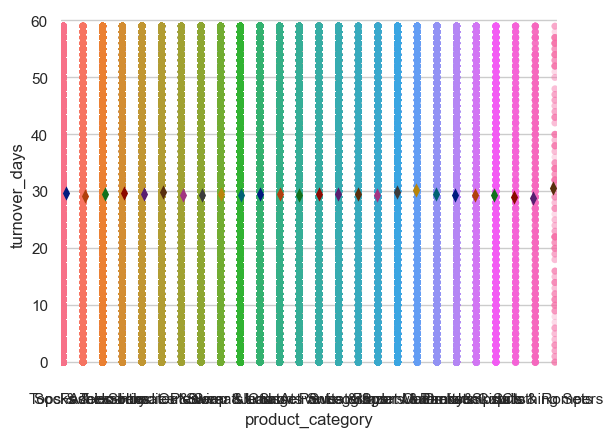

In [20]:
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=inventory, x="product_category", y="turnover_days", hue="product_category",
    dodge=True, alpha=.25, zorder=1, legend=False,
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=inventory, x="product_category", y="turnover_days", hue="product_category",
    dodge=.8 - .8 / 3, palette="dark", errorbar=None,
    markers="d", markersize=4, linestyle="none",
)

# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Tops & Tees'),
  Text(1, 0, 'Socks & Hosiery'),
  Text(2, 0, 'Accessories'),
  Text(3, 0, 'Socks'),
  Text(4, 0, 'Intimates'),
  Text(5, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(6, 0, 'Plus'),
  Text(7, 0, 'Swim'),
  Text(8, 0, 'Outerwear & Coats'),
  Text(9, 0, 'Sleep & Lounge'),
  Text(10, 0, 'Jeans'),
  Text(11, 0, 'Shorts'),
  Text(12, 0, 'Active'),
  Text(13, 0, 'Pants'),
  Text(14, 0, 'Sweaters'),
  Text(15, 0, 'Leggings'),
  Text(16, 0, 'Suits & Sport Coats'),
  Text(17, 0, 'Underwear'),
  Text(18, 0, 'Blazers & Jackets'),
  Text(19, 0, 'Maternity'),
  Text(20, 0, 'Dresses'),
  Text(21, 0, 'Pants & Capris'),
  Text(22, 0, 'Skirts'),
  Text(23, 0, 'Suits'),
  Text(24, 0, 'Jumpsuits & Rompers'),
  Text(25, 0, 'Clothing Sets')])

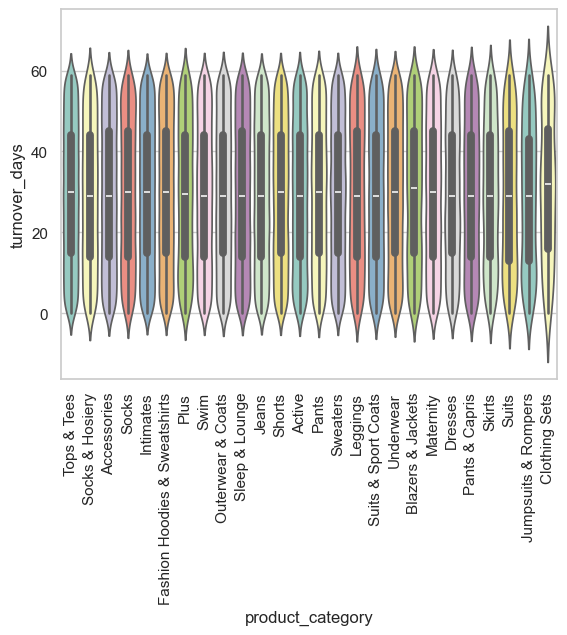

In [21]:
sns.violinplot(data=inventory, x='product_category', y='turnover_days',hue='product_category',palette="Set3")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [22]:
# Simple: Use inventory-items table
inventory_sql = """
WITH thelook_inventory_item AS (
SELECT
    id
    ,product_id
    ,created_at
    ,sold_at
    ,cost
    ,product_category
    ,product_name
    ,product_brand
    ,product_retail_price
    ,product_department
    ,product_sku
    ,product_distribution_center_id
    ,CASE WHEN sold_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_sold
    ,CASE WHEN sold_at IS NOT NULL THEN DATE_DIFF(sold_at,created_at,DAY) ELSE NULL END AS turnover_days
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
sold_unsold AS (
SELECT
    product_category
    ,COUNT(CASE WHEN is_sold IS TRUE THEN id ELSE NULL END) AS num_sold
    ,COUNT(CASE WHEN is_sold IS FALSE THEN id ELSE NULL END) AS num_unsold
FROM 
    thelook_inventory_item
GROUP BY
    product_category
)
SELECT
    product_category
    ,num_sold
    ,num_unsold
    ,num_unsold / (num_sold + num_unsold) AS percent_unsold
FROM
    sold_unsold
ORDER BY
    percent_unsold DESC
"""
pandas_gbq.read_gbq(inventory_sql)

## This shows that there's weirdness in how the IDs were generated. This dataset has ID integrity but it doesn't actually make sense when you join them.
## For the purposes of this exercise will use inventory_id on its own and ignore the status

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_category,num_sold,num_unsold,percent_unsold
0,Leggings,3175,5456,0.632140
1,Skirts,2135,3666,0.631960
2,Pants,7054,12103,0.631780
3,Active,9067,15535,0.631453
4,Sweaters,11088,18995,0.631420
5,Socks & Hosiery,3885,6654,0.631369
6,Blazers & Jackets,3263,5568,0.630506
7,Suits & Sport Coats,4995,8521,0.630438
8,Underwear,7589,12932,0.630184
9,Tops & Tees,12033,20501,0.630141


## Calculating Average Order Profit and Value

 *  Calculate average order value and profit
 *  Calculate average order value and profit by category
 *  Evaluate category as a percentage of order
 *  What are the mean and median? Both in terms of $ and percentage

In [23]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
aov_aop_sql = """
WITH thelook_order_product_details AS (
SELECT
    orders.order_id AS order_id
    ,products.category AS product_category
    ,order_items.id as order_item_id
    ,order_items.user_id
    ,products.id AS product_id
    ,order_items.sale_price AS item_revenue
    ,products.cost AS item_cost
    ,order_items.sale_price - products.cost AS item_profit
FROM
    `trumid-case.thelook_ecommerce.products` AS products
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items` AS order_items
ON
    products.id = order_items.product_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders`  AS orders
ON
    order_items.order_id = orders.order_id
WHERE
    orders.status != 'Cancelled'
AND
    order_items.returned_at IS NOT NULL
),
order_category_metrics AS (
SELECT
    product_category
    ,order_id
    ,AVG(item_revenue) AS order_category_revenue
    ,AVG(item_profit) AS order_category_profit
FROM
    thelook_order_product_details
GROUP BY
    product_category
    ,order_id
),
order_metrics AS (
SELECT
    order_id
    ,AVG(item_revenue) AS order_revenue
    ,AVG(item_profit) AS order_profit
FROM
    thelook_order_product_details
GROUP BY
    order_id
)
SELECT
    order_category_metrics.product_category
    ,order_category_metrics.order_id
    ,order_category_metrics.order_category_revenue
    ,order_category_metrics.order_category_profit
    ,order_metrics.order_revenue
    ,order_metrics.order_profit
    ,order_category_metrics.order_category_revenue / order_metrics.order_revenue AS category_percent_of_profit
    ,order_category_metrics.order_category_profit / order_metrics.order_profit AS category_percent_of_revenue
FROM 
    order_category_metrics
LEFT JOIN
    order_metrics
ON
    order_category_metrics.order_id = order_metrics.order_id
ORDER BY
    category_percent_of_profit DESC
"""
aov_aop = pandas_gbq.read_gbq(aov_aop_sql)
aov_aop

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_category,order_id,order_category_revenue,order_category_profit,order_revenue,order_profit,category_percent_of_profit,category_percent_of_revenue
0,Active,58630,695.00,433.679999,190.4850,116.056335,3.648581,3.736806
1,Active,77684,903.00,527.351999,266.2100,155.075364,3.392059,3.400618
2,Outerwear & Coats,54015,137.50,80.437500,41.7575,24.303255,3.292822,3.309742
3,Sweaters,47666,194.00,107.282000,59.0600,31.044203,3.284795,3.455782
4,Outerwear & Coats,20879,239.00,129.299000,72.7850,39.567702,3.283644,3.267791
...,...,...,...,...,...,...,...,...
17590,Dresses,84375,8.56,4.485440,217.1400,124.920110,0.039422,0.035906
17591,Accessories,3963,4.50,2.781000,118.3725,62.006133,0.038016,0.044850
17592,Intimates,58630,6.98,3.266640,190.4850,116.056335,0.036643,0.028147
17593,Accessories,18755,5.83,3.713710,176.9150,86.246855,0.032954,0.043059


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Active'),
  Text(1, 0, 'Outerwear & Coats'),
  Text(2, 0, 'Sweaters'),
  Text(3, 0, 'Skirts'),
  Text(4, 0, 'Jeans'),
  Text(5, 0, 'Swim'),
  Text(6, 0, 'Socks'),
  Text(7, 0, 'Suits & Sport Coats'),
  Text(8, 0, 'Blazers & Jackets'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Accessories'),
  Text(11, 0, 'Intimates'),
  Text(12, 0, 'Dresses'),
  Text(13, 0, 'Pants'),
  Text(14, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(15, 0, 'Sleep & Lounge'),
  Text(16, 0, 'Shorts'),
  Text(17, 0, 'Pants & Capris'),
  Text(18, 0, 'Suits'),
  Text(19, 0, 'Clothing Sets'),
  Text(20, 0, 'Plus'),
  Text(21, 0, 'Maternity'),
  Text(22, 0, 'Jumpsuits & Rompers'),
  Text(23, 0, 'Underwear'),
  Text(24, 0, 'Leggings'),
  Text(25, 0, 'Socks & Hosiery')])

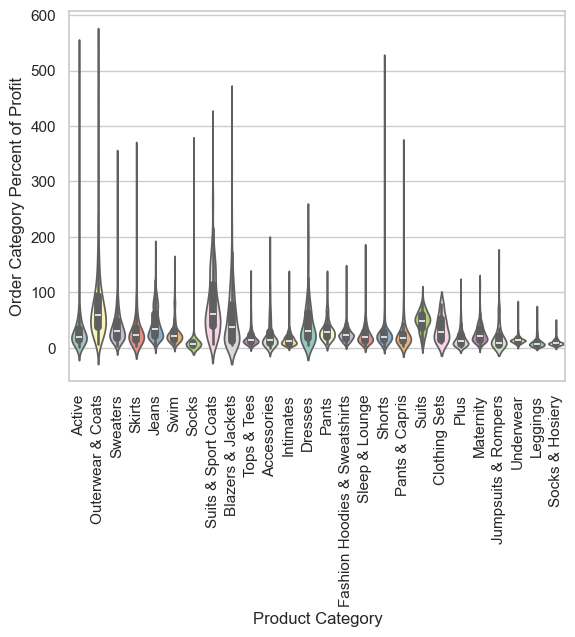

In [24]:
sns.violinplot(data=aov_aop, x='product_category', y='order_category_profit',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Order Category Percent of Profit')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [25]:
aov_aop.groupby('product_category')['order_category_profit'].median().reset_index().sort_values('order_category_profit')

,product_category,order_category_profit
18,Socks,6.047640
9,Leggings,7.237740
19,Socks & Hosiery,8.340305
8,Jumpsuits & Rompers,9.372900
14,Plus,11.852610
6,Intimates,12.441000
25,Underwear,13.330000
24,Tops & Tees,13.945350
0,Accessories,14.100000
13,Pants & Capris,17.048640


## Calculating Profit Margin and Contribution to Profit
 *  What does the distribution of profit margin look like within a given product category? Average for a product category? **Done**
 *  Define profitability - profit made per unit; compare what you would expect at full price v. actual **Done**
 *  Also consider contribution to total profits (fulfilled and NOT returned) 

In [26]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    *
FROM
    thelook_products

"""
product_with_margins = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Swim'),
  Text(1, 0, 'Jeans'),
  Text(2, 0, 'Pants'),
  Text(3, 0, 'Socks'),
  Text(4, 0, 'Active'),
  Text(5, 0, 'Shorts'),
  Text(6, 0, 'Sweaters'),
  Text(7, 0, 'Underwear'),
  Text(8, 0, 'Accessories'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Sleep & Lounge'),
  Text(11, 0, 'Outerwear & Coats'),
  Text(12, 0, 'Suits & Sport Coats'),
  Text(13, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(14, 0, 'Plus'),
  Text(15, 0, 'Suits'),
  Text(16, 0, 'Skirts'),
  Text(17, 0, 'Dresses'),
  Text(18, 0, 'Leggings'),
  Text(19, 0, 'Intimates'),
  Text(20, 0, 'Maternity'),
  Text(21, 0, 'Clothing Sets'),
  Text(22, 0, 'Pants & Capris'),
  Text(23, 0, 'Socks & Hosiery'),
  Text(24, 0, 'Blazers & Jackets'),
  Text(25, 0, 'Jumpsuits & Rompers')])

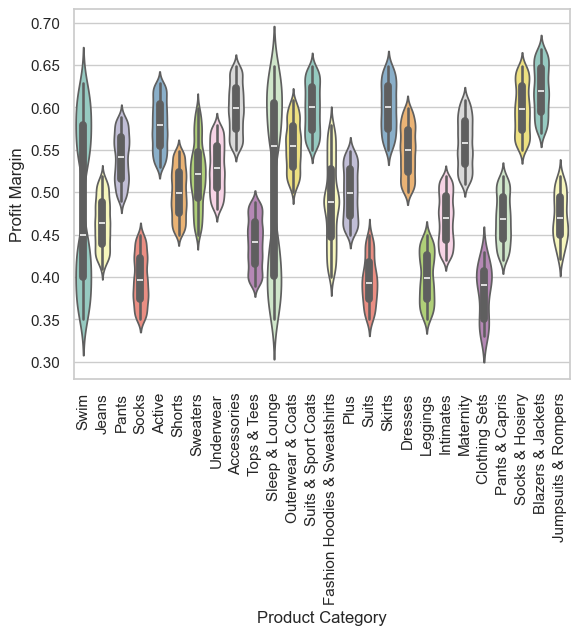

In [27]:
sns.violinplot(data=product_with_margins, x='product_category', y='profit_margin',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Profit Margin')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

<Axes: xlabel='profit_margin', ylabel='product_category'>

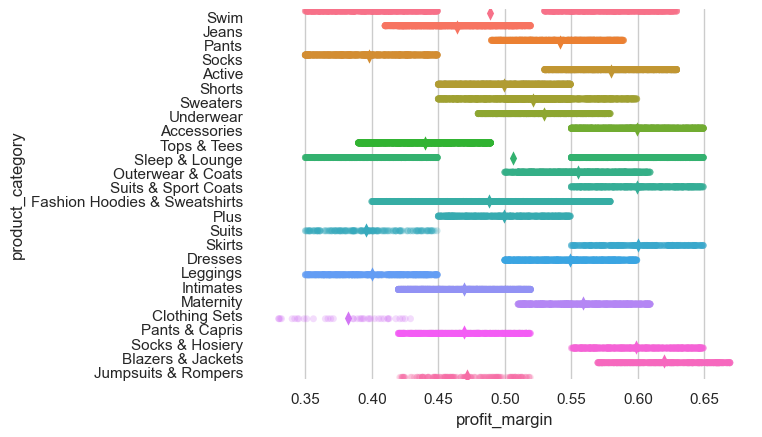

In [28]:
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
sns.stripplot(
    data=product_with_margins, x="profit_margin", y="product_category", hue="product_category",
    dodge=True, alpha=.25, zorder=1, legend=False,
)
sns.pointplot(
    data=product_with_margins, x="profit_margin", y="product_category", hue="product_category",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", markersize=4, linestyle="none",
)
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels


### Now look at this against what's sold

- For items with biggest srpead of high v low margin, what doe sales look like?
- What areas are contributing most to profits? least?

In [29]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    id as order_item_id
    ,product_id
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
)
SELECT
    status
    ,product_id
    ,COUNT(order_item_id) AS quantity
FROM
    thelook_order_items
GROUP BY
    status
    ,product_id
"""
volume_sold_by_status = pandas_gbq.read_gbq(query)
volume_sold_by_status['status'].unique()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


array(['Shipped', 'Processing', 'Complete', 'Cancelled', 'Returned'],
      dtype=object)

In [30]:
volume_sold_by_status.head()

,status,product_id,quantity
0,Shipped,9414,6
1,Shipped,12527,6
2,Shipped,25329,6
3,Shipped,24961,6
4,Shipped,5714,6


To Do: join two dfs, exclude cancelled or returned. 
* Breakout total profit by category
* Look at profit and quantity (i.e. are there low margin items that aren't selling a lot?)

In [31]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    product_id
    ,status
    ,COUNT(id) as quantity
FROM
    `trumid-case.thelook_ecommerce.order_items`
GROUP BY
    product_id
    ,status
),
thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    thelook_products.product_id
    ,thelook_products.product_category
    ,thelook_products.product_sku
    ,thelook_products.product_cost
    ,thelook_products.retail_price
    ,thelook_products.gross_profit
    ,thelook_products.profit_margin
    ,thelook_order_items.quantity
    ,COALESCE(thelook_order_items.status,'Never Ordered') as order_status
    ,COALESCE(thelook_order_items.quantity,0) as quantity
FROM
    thelook_products
LEFT JOIN
    thelook_order_items
ON
    thelook_products.product_id = thelook_order_items.product_id
"""
product_by_order_status = pandas_gbq.read_gbq(query) # 54 products were never ordered

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [32]:
product_by_order_status.head()

,product_id,product_category,product_sku,product_cost,retail_price,gross_profit,profit_margin,quantity,order_status,quantity_1
0,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Shipped,1
1,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,4,Complete,4
2,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Returned,1
3,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Cancelled,1
4,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Processing,1


In [33]:
product_by_order_status['order_status'].unique()

array(['Shipped', 'Complete', 'Returned', 'Cancelled', 'Processing',
       'Never Ordered'], dtype=object)

In [34]:
product_by_order_status.groupby(['product_category','order_status']).count().query("order_status == 'Never Ordered'")

,,product_id,product_sku,product_cost,retail_price,gross_profit,profit_margin,quantity,quantity_1
product_category,order_status,,,,,,,,
Accessories,Never Ordered,4,4,4,4,4,4,0,4
Active,Never Ordered,4,4,4,4,4,4,0,4
Blazers & Jackets,Never Ordered,1,1,1,1,1,1,0,1
Dresses,Never Ordered,3,3,3,3,3,3,0,3
Fashion Hoodies & Sweatshirts,Never Ordered,7,7,7,7,7,7,0,7
Intimates,Never Ordered,10,10,10,10,10,10,0,10
Jeans,Never Ordered,1,1,1,1,1,1,0,1
Jumpsuits & Rompers,Never Ordered,2,2,2,2,2,2,0,2
Leggings,Never Ordered,4,4,4,4,4,4,0,4


In [35]:
product_orders = product_by_order_status.query("order_status == 'Complete' | order_status == 'Shipped' | order_status == 'Processing'")

In [36]:
product_orders = pd.DataFrame(product_orders).reset_index()

<Axes: xlabel='profit_margin', ylabel='product_category'>

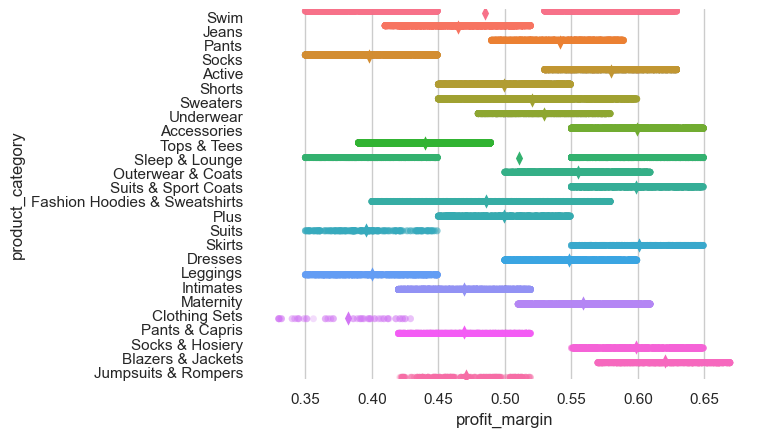

In [37]:
sns.set_theme(style="whitegrid")


# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
sns.stripplot(
    data=product_orders, x="profit_margin", y="product_category", hue="product_category",
    dodge=True, alpha=.25, zorder=1, legend=False,
)
sns.pointplot(
    data=product_orders, x="profit_margin", y="product_category", hue="product_category",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", markersize=4, linestyle="none",
)
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels


In [38]:
product_orders.query("product_category=='Accessories'").sum()

index                                                       194535958
product_id                                                   81412715
product_category    AccessoriesAccessoriesAccessoriesAccessoriesAc...
product_sku         789334DE6DAA80D83AB4ACB6A4BF5AC7E74843B99DA8B2...
product_cost                                             61975.025532
retail_price                                            154627.119912
gross_profit                                              92652.09438
profit_margin                                             2209.681005
quantity                                                         7353
order_status        ShippedShippedCompleteProcessingShippedComplet...
quantity_1                                                       7353
dtype: object

In [39]:
product_orders['total_profit'] = product_orders['gross_profit'].sum()
product_orders['percent_of_profit'] = product_orders['gross_profit'] / product_orders['total_profit']
product_orders['total_cost'] = product_orders['product_cost'].sum()
product_orders['percent_of_cost'] = product_orders['product_cost'] / product_orders['total_cost']
product_orders['total_revenue'] = product_orders['retail_price'].sum()
product_orders['percent_of_revenue'] = product_orders['retail_price'] / product_orders['total_revenue']
product_orders

,index,product_id,product_category,product_sku,product_cost,retail_price,gross_profit,profit_margin,quantity,order_status,quantity_1,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
0,0,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Shipped,1,2.101952e+06,0.000027,1.946204e+06,0.000048,4.048156e+06,0.000037
1,1,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,4,Complete,4,2.101952e+06,0.000027,1.946204e+06,0.000048,4.048156e+06,0.000037
2,4,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,1,Processing,1,2.101952e+06,0.000027,1.946204e+06,0.000048,4.048156e+06,0.000037
3,5,27445,Swim,2AB7D3B23574C3DEA2BD278AFD0939AB,24.719661,38.990002,14.270340,0.366,1,Shipped,1,2.101952e+06,0.000007,1.946204e+06,0.000013,4.048156e+06,0.000010
4,6,27445,Swim,2AB7D3B23574C3DEA2BD278AFD0939AB,24.719661,38.990002,14.270340,0.366,1,Complete,1,2.101952e+06,0.000007,1.946204e+06,0.000013,4.048156e+06,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68160,99278,1852,Fashion Hoodies & Sweatshirts,EB1E78328C46506B46A4AC4A1E378B91,17.674240,34.520000,16.845760,0.488,2,Shipped,2,2.101952e+06,0.000008,1.946204e+06,0.000009,4.048156e+06,0.000009
68161,99279,1852,Fashion Hoodies & Sweatshirts,EB1E78328C46506B46A4AC4A1E378B91,17.674240,34.520000,16.845760,0.488,2,Complete,2,2.101952e+06,0.000008,1.946204e+06,0.000009,4.048156e+06,0.000009
68162,99282,1852,Fashion Hoodies & Sweatshirts,EB1E78328C46506B46A4AC4A1E378B91,17.674240,34.520000,16.845760,0.488,1,Processing,1,2.101952e+06,0.000008,1.946204e+06,0.000009,4.048156e+06,0.000009
68163,99283,2296,Fashion Hoodies & Sweatshirts,130F1A8E9E102707F3F91B010F151B0B,17.533261,36.990002,19.456741,0.526,4,Shipped,4,2.101952e+06,0.000009,1.946204e+06,0.000009,4.048156e+06,0.000009


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Swim'),
  Text(1, 0, 'Jeans'),
  Text(2, 0, 'Pants'),
  Text(3, 0, 'Socks'),
  Text(4, 0, 'Active'),
  Text(5, 0, 'Shorts'),
  Text(6, 0, 'Sweaters'),
  Text(7, 0, 'Underwear'),
  Text(8, 0, 'Accessories'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Sleep & Lounge'),
  Text(11, 0, 'Outerwear & Coats'),
  Text(12, 0, 'Suits & Sport Coats'),
  Text(13, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(14, 0, 'Plus'),
  Text(15, 0, 'Suits'),
  Text(16, 0, 'Skirts'),
  Text(17, 0, 'Dresses'),
  Text(18, 0, 'Leggings'),
  Text(19, 0, 'Intimates'),
  Text(20, 0, 'Maternity'),
  Text(21, 0, 'Clothing Sets'),
  Text(22, 0, 'Pants & Capris'),
  Text(23, 0, 'Socks & Hosiery'),
  Text(24, 0, 'Blazers & Jackets'),
  Text(25, 0, 'Jumpsuits & Rompers')])

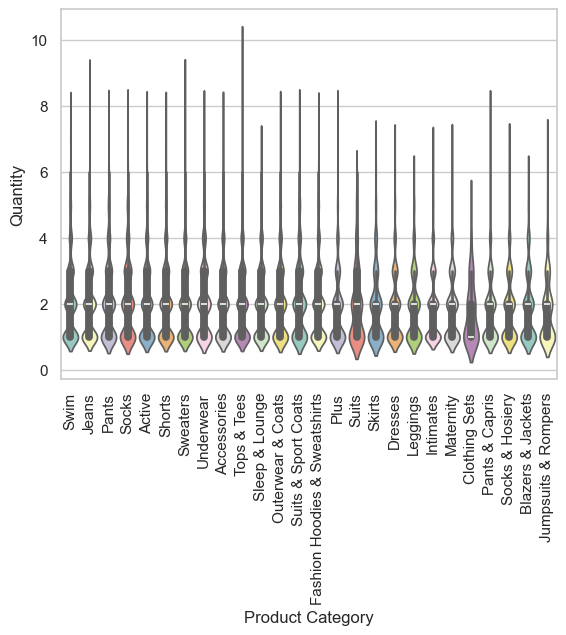

In [41]:
sns.violinplot(data=product_orders, x='product_category', y='quantity',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Quantity')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

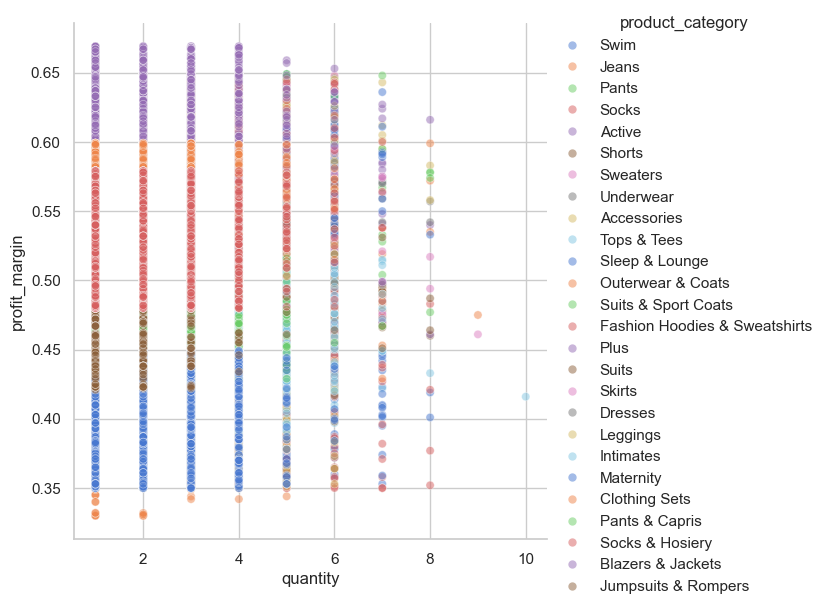

In [42]:
sns.relplot(x="quantity", y="profit_margin", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=product_orders)

In [43]:
import numpy as np
agg_product_details = product_orders.groupby('product_category').agg({"profit_margin": ['mean'],
                                                "retail_price": ['mean', 'sum'],
                                                "product_cost": ['mean', 'sum'],
                                                "gross_profit": ['mean', 'sum'],
                                                "quantity": ['sum']})
agg_product_details.columns = agg_product_details.columns.map('_'.join).str.strip('_')
agg_product_details = agg_product_details.reset_index()
agg_product_details.head()

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum
0,Accessories,0.598992,41.915728,154627.119912,16.799953,61975.025532,25.115775,92652.094380,7353
1,Active,0.579373,50.419129,170668.750061,21.141771,71564.893951,29.277358,99103.856110,6863
2,Blazers & Jackets,0.620621,93.360859,119595.260254,35.355614,45290.542049,58.005245,74304.718205,2447
3,Clothing Sets,0.382209,85.847674,7382.900003,53.072025,4564.194171,32.775649,2818.705833,149
4,Dresses,0.548460,84.387230,183711.000397,38.008866,82745.300203,46.378365,100965.700193,4120


In [44]:
agg_product_details['total_profit'] = agg_product_details['gross_profit_sum'].sum()
agg_product_details['percent_of_profit'] = agg_product_details['gross_profit_sum'] / agg_product_details['total_profit']
agg_product_details['total_cost'] = agg_product_details['product_cost_sum'].sum()
agg_product_details['percent_of_cost'] = agg_product_details['product_cost_sum'] / agg_product_details['total_cost']
agg_product_details['total_revenue'] = agg_product_details['retail_price_sum'].sum()
agg_product_details['percent_of_revenue'] = agg_product_details['retail_price_sum'] / agg_product_details['total_revenue']
agg_product_details['realized_profit_margin'] = agg_product_details['gross_profit_sum'] / agg_product_details['product_cost_sum']
agg_product_details.sort_values('realized_profit_margin',ascending=False)

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,realized_profit_margin
2,Blazers & Jackets,0.620621,93.360859,119595.260254,35.355614,45290.542049,58.005245,74304.718205,2447,2.101952e+06,0.035350,1.946204e+06,0.023271,4.048156e+06,0.029543,1.640623
16,Skirts,0.600579,52.493318,44619.320084,20.932151,17792.328656,31.561166,26826.991428,1641,2.101952e+06,0.012763,1.946204e+06,0.009142,4.048156e+06,0.011022,1.507784
0,Accessories,0.598992,41.915728,154627.119912,16.799953,61975.025532,25.115775,92652.094380,7353,2.101952e+06,0.044079,1.946204e+06,0.031844,4.048156e+06,0.038197,1.494991
21,Suits & Sport Coats,0.598733,126.232680,227471.289719,50.732676,91420.282491,75.500004,136051.007227,3735,2.101952e+06,0.064726,1.946204e+06,0.046974,4.048156e+06,0.056191,1.488193
19,Socks & Hosiery,0.598544,16.738643,25526.429942,6.728460,10260.901180,10.010183,15265.528762,2889,2.101952e+06,0.007263,1.946204e+06,0.005272,4.048156e+06,0.006306,1.487738
1,Active,0.579373,50.419129,170668.750061,21.141771,71564.893951,29.277358,99103.856110,6863,2.101952e+06,0.047148,1.946204e+06,0.036772,4.048156e+06,0.042160,1.384811
10,Maternity,0.558721,51.678582,105682.699793,22.797847,46621.597039,28.880735,59061.102754,3911,2.101952e+06,0.028098,1.946204e+06,0.023955,4.048156e+06,0.026106,1.266819
11,Outerwear & Coats,0.554933,145.792597,489425.749542,64.892040,217842.577451,80.900558,271583.172091,6880,2.101952e+06,0.129205,1.946204e+06,0.111932,4.048156e+06,0.120901,1.246695
4,Dresses,0.548460,84.387230,183711.000397,38.008866,82745.300203,46.378365,100965.700193,4120,2.101952e+06,0.048034,1.946204e+06,0.042516,4.048156e+06,0.045381,1.220199
12,Pants,0.541243,60.370817,153824.840536,27.685767,70543.333236,32.685050,83281.507300,5288,2.101952e+06,0.039621,1.946204e+06,0.036247,4.048156e+06,0.037999,1.180572


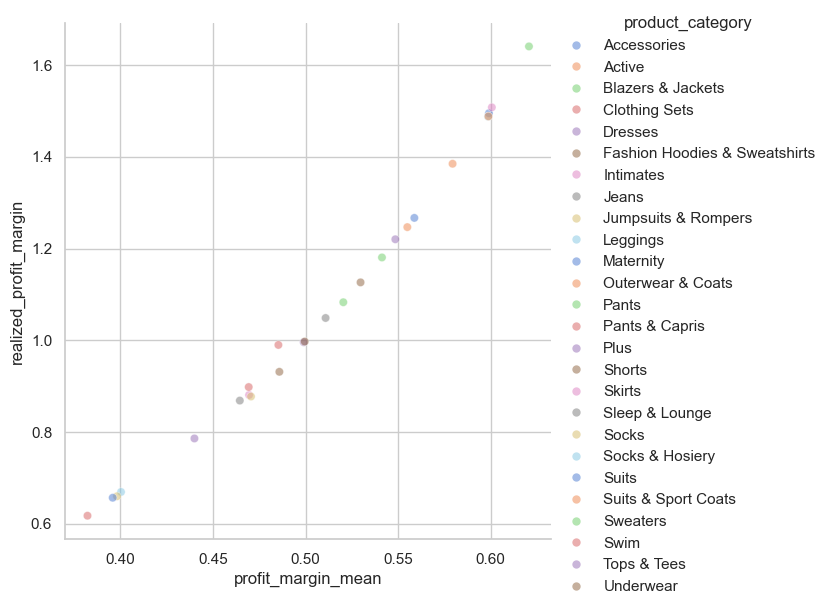

In [45]:
sns.relplot(x="profit_margin_mean", y="realized_profit_margin", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details) # redo but with full inventory? 

In [46]:
agg_product_details.query("profit_margin_mean <= 0.45 & realized_profit_margin <= 0.8")

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,realized_profit_margin
3,Clothing Sets,0.382209,85.847674,7382.900003,53.072025,4564.194171,32.775649,2818.705833,149,2.101952e+06,0.001341,1.946204e+06,0.002345,4.048156e+06,0.001824,0.617569
9,Leggings,0.400324,27.339443,33846.229970,16.377443,20275.274228,10.962000,13570.955742,2375,2.101952e+06,0.006456,1.946204e+06,0.010418,4.048156e+06,0.008361,0.669335
18,Socks,0.398148,20.441624,45053.340019,12.314220,27140.540431,8.127405,17912.799588,4629,2.101952e+06,0.008522,1.946204e+06,0.013945,4.048156e+06,0.011129,0.660002
20,Suits,0.395836,116.039571,48736.619997,70.039159,29416.446601,46.000413,19320.173396,824,2.101952e+06,0.009192,1.946204e+06,0.015115,4.048156e+06,0.012039,0.656781
24,Tops & Tees,0.439964,41.491609,184181.250646,23.231067,103122.704684,18.260542,81058.545962,8969,2.101952e+06,0.038563,1.946204e+06,0.052987,4.048156e+06,0.045498,0.786040


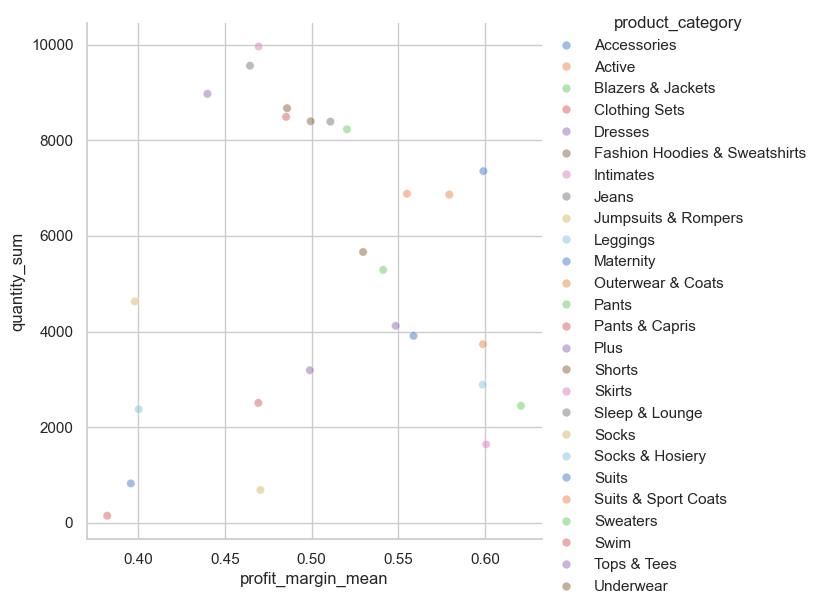

In [47]:
sns.relplot(x="profit_margin_mean", y="quantity_sum", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

In [48]:
agg_product_details.query("profit_margin_mean <= 0.45 & percent_of_profit <= 0.04")

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,realized_profit_margin
3,Clothing Sets,0.382209,85.847674,7382.900003,53.072025,4564.194171,32.775649,2818.705833,149,2.101952e+06,0.001341,1.946204e+06,0.002345,4.048156e+06,0.001824,0.617569
9,Leggings,0.400324,27.339443,33846.229970,16.377443,20275.274228,10.962000,13570.955742,2375,2.101952e+06,0.006456,1.946204e+06,0.010418,4.048156e+06,0.008361,0.669335
18,Socks,0.398148,20.441624,45053.340019,12.314220,27140.540431,8.127405,17912.799588,4629,2.101952e+06,0.008522,1.946204e+06,0.013945,4.048156e+06,0.011129,0.660002
20,Suits,0.395836,116.039571,48736.619997,70.039159,29416.446601,46.000413,19320.173396,824,2.101952e+06,0.009192,1.946204e+06,0.015115,4.048156e+06,0.012039,0.656781
24,Tops & Tees,0.439964,41.491609,184181.250646,23.231067,103122.704684,18.260542,81058.545962,8969,2.101952e+06,0.038563,1.946204e+06,0.052987,4.048156e+06,0.045498,0.786040


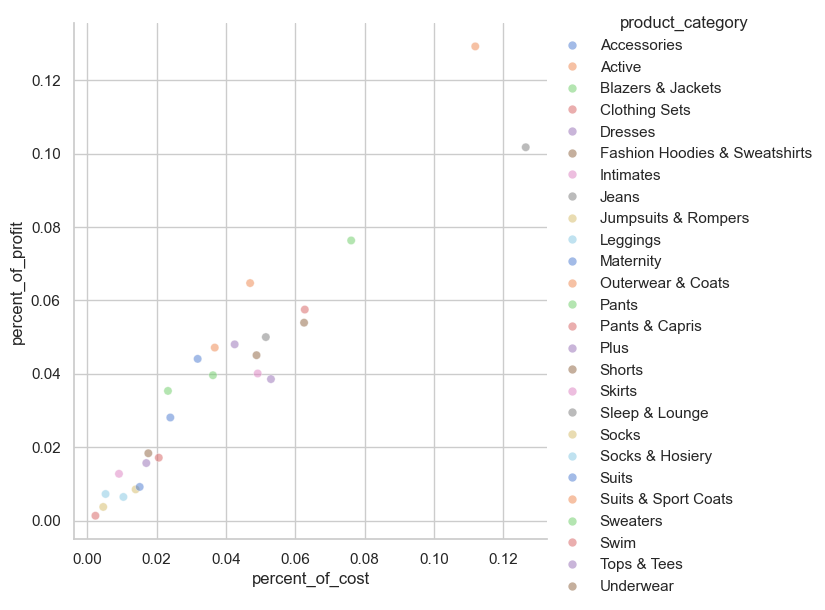

In [49]:
sns.relplot(x="percent_of_cost", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

<Axes: >

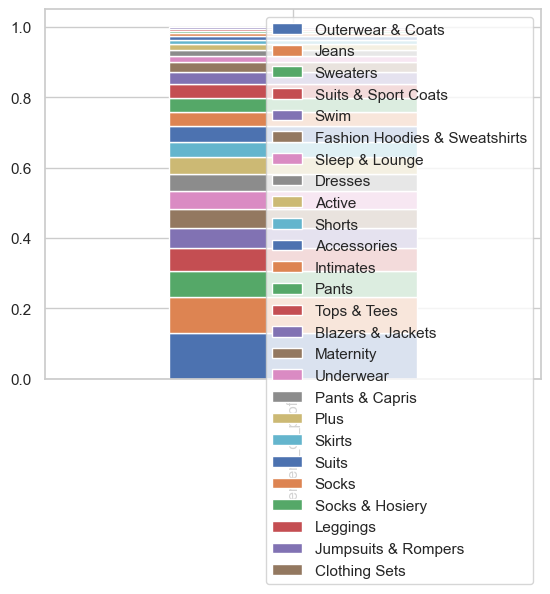

In [50]:
category_profit = agg_product_details[['product_category','percent_of_profit']].sort_values('percent_of_profit',ascending=False).transpose()
headers = category_profit.iloc[0].values
category_profit.columns = headers
category_profit.query("Accessories != 'Accessories'").plot(kind='bar', stacked=True)

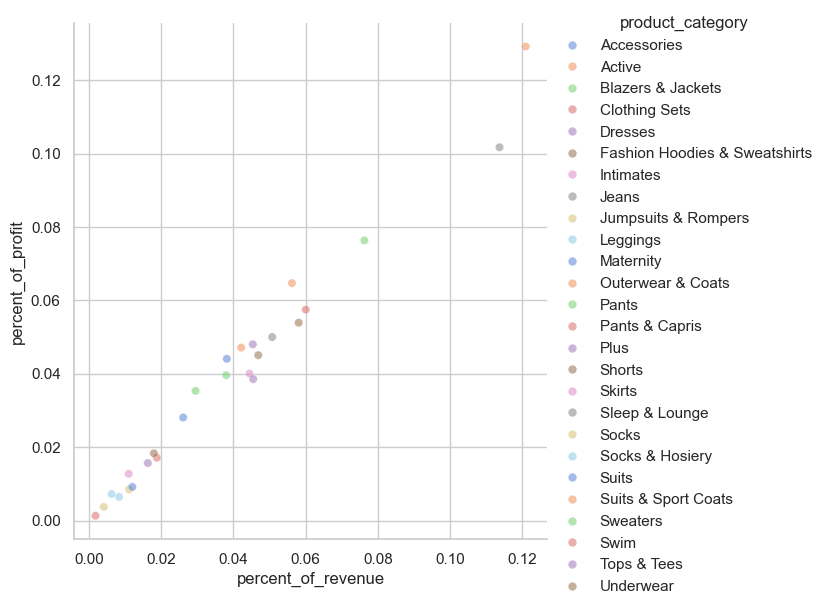

In [51]:
sns.relplot(x="percent_of_revenue", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

In [52]:
agg_product_details.query("percent_of_cost > percent_of_profit").sort_values('percent_of_profit')

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,realized_profit_margin
3,Clothing Sets,0.382209,85.847674,7382.900003,53.072025,4564.194171,32.775649,2818.705833,149,2.101952e+06,0.001341,1.946204e+06,0.002345,4.048156e+06,0.001824,0.617569
8,Jumpsuits & Rompers,0.470521,44.228921,16806.990066,23.557747,8951.944035,20.671174,7855.046031,688,2.101952e+06,0.003737,1.946204e+06,0.004600,4.048156e+06,0.004152,0.877468
9,Leggings,0.400324,27.339443,33846.229970,16.377443,20275.274228,10.962000,13570.955742,2375,2.101952e+06,0.006456,1.946204e+06,0.010418,4.048156e+06,0.008361,0.669335
18,Socks,0.398148,20.441624,45053.340019,12.314220,27140.540431,8.127405,17912.799588,4629,2.101952e+06,0.008522,1.946204e+06,0.013945,4.048156e+06,0.011129,0.660002
20,Suits,0.395836,116.039571,48736.619997,70.039159,29416.446601,46.000413,19320.173396,824,2.101952e+06,0.009192,1.946204e+06,0.015115,4.048156e+06,0.012039,0.656781
14,Plus,0.498995,38.981680,66112.930112,19.531774,33125.889328,19.449906,32987.040783,3191,2.101952e+06,0.015694,1.946204e+06,0.017021,4.048156e+06,0.016332,0.995808
13,Pants & Capris,0.469278,56.267652,76186.400325,29.644612,40138.804632,26.623040,36047.595693,2508,2.101952e+06,0.017150,1.946204e+06,0.020624,4.048156e+06,0.018820,0.898073
24,Tops & Tees,0.439964,41.491609,184181.250646,23.231067,103122.704684,18.260542,81058.545962,8969,2.101952e+06,0.038563,1.946204e+06,0.052987,4.048156e+06,0.045498,0.786040
6,Intimates,0.469458,33.801580,179959.610262,17.971534,95680.445482,15.830046,84279.164780,9961,2.101952e+06,0.040096,1.946204e+06,0.049163,4.048156e+06,0.044455,0.880840
15,Shorts,0.499509,45.870484,189766.190543,22.967024,95014.580324,22.903459,94751.610219,8396,2.101952e+06,0.045078,1.946204e+06,0.048820,4.048156e+06,0.046877,0.997232


In [53]:
product_orders.query("product_category == 'Clothing Sets'").sort_values('profit_margin')

,index,product_id,product_category,product_sku,product_cost,retail_price,gross_profit,profit_margin,quantity,order_status,quantity_1,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
58406,85107,8054,Clothing Sets,47E51E9D11CF800FF08674DBB68A48AB,66.993298,99.989998,32.996699,0.330,2,Shipped,2,2.101952e+06,0.000016,1.946204e+06,0.000034,4.048156e+06,0.000025
58407,85108,8054,Clothing Sets,47E51E9D11CF800FF08674DBB68A48AB,66.993298,99.989998,32.996699,0.330,2,Complete,2,2.101952e+06,0.000016,1.946204e+06,0.000034,4.048156e+06,0.000025
58408,85109,8054,Clothing Sets,47E51E9D11CF800FF08674DBB68A48AB,66.993298,99.989998,32.996699,0.330,2,Processing,2,2.101952e+06,0.000016,1.946204e+06,0.000034,4.048156e+06,0.000025
58381,85072,8034,Clothing Sets,CC4AF25FA9D2D5C953496579B75F6F6C,73.693298,109.989998,36.296700,0.330,1,Shipped,1,2.101952e+06,0.000017,1.946204e+06,0.000038,4.048156e+06,0.000027
58382,85073,8034,Clothing Sets,CC4AF25FA9D2D5C953496579B75F6F6C,73.693298,109.989998,36.296700,0.330,1,Complete,1,2.101952e+06,0.000017,1.946204e+06,0.000038,4.048156e+06,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58384,85075,8033,Clothing Sets,FC5B3186F1CF0DAECE964F78259B7BA0,11.494250,19.990000,8.495750,0.425,2,Shipped,2,2.101952e+06,0.000004,1.946204e+06,0.000006,4.048156e+06,0.000005
58386,85078,8033,Clothing Sets,FC5B3186F1CF0DAECE964F78259B7BA0,11.494250,19.990000,8.495750,0.425,1,Processing,1,2.101952e+06,0.000004,1.946204e+06,0.000006,4.048156e+06,0.000005
58385,85076,8033,Clothing Sets,FC5B3186F1CF0DAECE964F78259B7BA0,11.494250,19.990000,8.495750,0.425,4,Complete,4,2.101952e+06,0.000004,1.946204e+06,0.000006,4.048156e+06,0.000005
58399,85099,8029,Clothing Sets,BECC353586042B6DBCC42C1B794C37B6,31.970291,55.990002,24.019711,0.429,2,Complete,2,2.101952e+06,0.000011,1.946204e+06,0.000016,4.048156e+06,0.000014


In [54]:
agg_product_details['profitability'] = agg_product_details['gross_profit_sum'] / agg_product_details['product_cost_sum']
agg_product_details.sort_values('profitability')

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,realized_profit_margin,profitability
3,Clothing Sets,0.382209,85.847674,7382.900003,53.072025,4564.194171,32.775649,2818.705833,149,2.101952e+06,0.001341,1.946204e+06,0.002345,4.048156e+06,0.001824,0.617569,0.617569
20,Suits,0.395836,116.039571,48736.619997,70.039159,29416.446601,46.000413,19320.173396,824,2.101952e+06,0.009192,1.946204e+06,0.015115,4.048156e+06,0.012039,0.656781,0.656781
18,Socks,0.398148,20.441624,45053.340019,12.314220,27140.540431,8.127405,17912.799588,4629,2.101952e+06,0.008522,1.946204e+06,0.013945,4.048156e+06,0.011129,0.660002,0.660002
9,Leggings,0.400324,27.339443,33846.229970,16.377443,20275.274228,10.962000,13570.955742,2375,2.101952e+06,0.006456,1.946204e+06,0.010418,4.048156e+06,0.008361,0.669335,0.669335
24,Tops & Tees,0.439964,41.491609,184181.250646,23.231067,103122.704684,18.260542,81058.545962,8969,2.101952e+06,0.038563,1.946204e+06,0.052987,4.048156e+06,0.045498,0.786040,0.786040
7,Jeans,0.464473,97.708237,460010.380762,52.290316,246182.807278,45.417921,213827.573484,9558,2.101952e+06,0.101728,1.946204e+06,0.126494,4.048156e+06,0.113635,0.868572,0.868572
8,Jumpsuits & Rompers,0.470521,44.228921,16806.990066,23.557747,8951.944035,20.671174,7855.046031,688,2.101952e+06,0.003737,1.946204e+06,0.004600,4.048156e+06,0.004152,0.877468,0.877468
6,Intimates,0.469458,33.801580,179959.610262,17.971534,95680.445482,15.830046,84279.164780,9961,2.101952e+06,0.040096,1.946204e+06,0.049163,4.048156e+06,0.044455,0.880840,0.880840
13,Pants & Capris,0.469278,56.267652,76186.400325,29.644612,40138.804632,26.623040,36047.595693,2508,2.101952e+06,0.017150,1.946204e+06,0.020624,4.048156e+06,0.018820,0.898073,0.898073
5,Fashion Hoodies & Sweatshirts,0.485834,54.156982,235095.460141,28.041531,121728.286920,26.115451,113367.173221,8669,2.101952e+06,0.053934,1.946204e+06,0.062547,4.048156e+06,0.058075,0.931313,0.931313


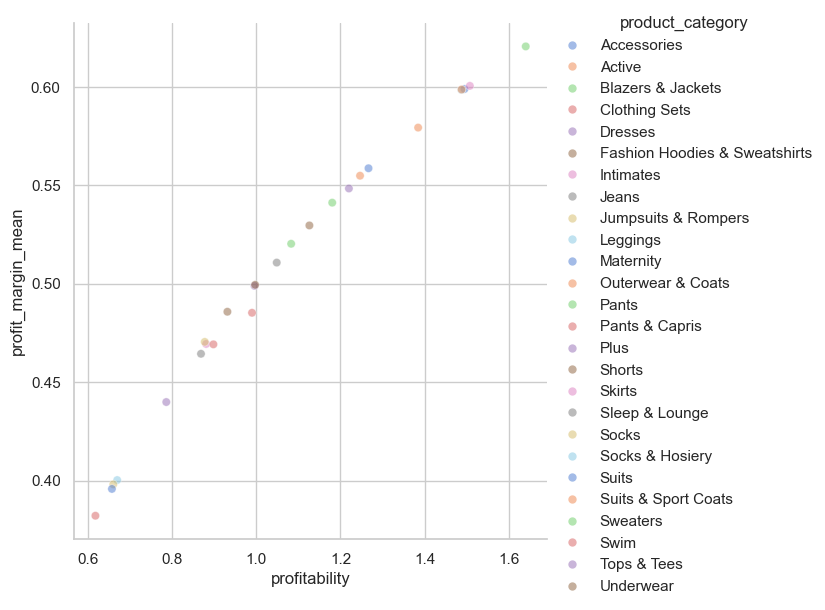

In [55]:
sns.relplot(x="profitability", y="profit_margin_mean", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

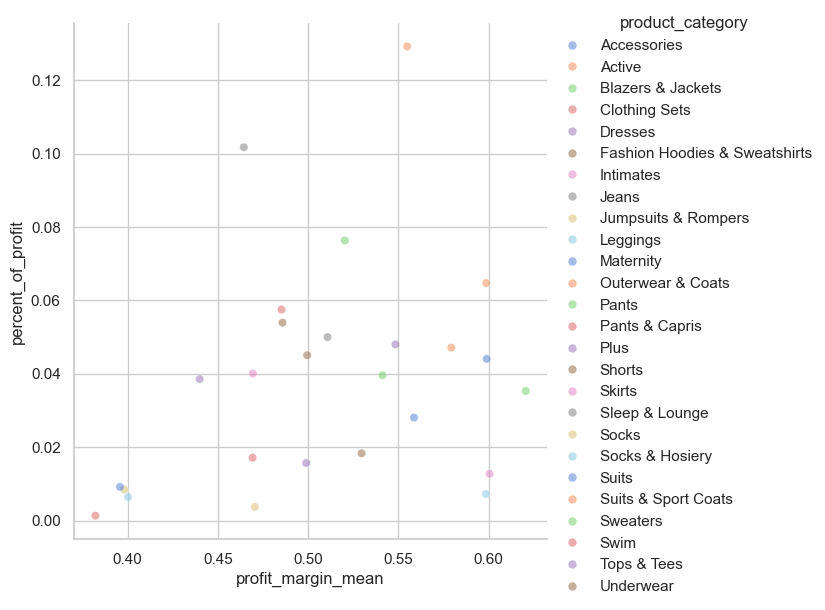

In [56]:
sns.relplot(x="profit_margin_mean", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

### Takeways:
* Items like clothing sets, jumpsuits/rompers, socks, suits have low profitability (both on margins and overall).
* Active, suits/sportcoats/blazers are all high margin and high profitability
* All items are sold full price, so could consider whether there's price sensitivity on items that don't sell (such as?)


### Next Steps
* Look at item turnover, average order value and profit per order, categories purchased by highest aov/aop users

In [57]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,user_id
    ,order_id
    ,product_id
    ,sale_price
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status != 'Returned' AND status != 'Cancelled'
),
order_product_details AS (
SELECT
   thelook_orderitems.user_id
   ,thelook_orderitems.order_id
   ,thelook_orderitems.order_item_id
   ,thelook_products.category
   ,thelook_products.product_id
   ,thelook_orderitems.sale_price
   ,thelook_products.cost
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    order_id
    ,category
    ,COUNT(order_item_id) AS count_order_items
    ,COUNT(DISTINCT product_id) AS count_products
    ,SUM(sale_price) AS order_category_revenue
    ,SUM(cost) AS order_category_cost
    ,SUM(sale_price - cost) AS order_category_profit
FROM
    order_product_details
GROUP BY
    order_id
    ,category
ORDER BY
    count_order_items DESC
"""
order_category_spend = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [58]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,user_id
    ,order_id
    ,product_id
    ,sale_price
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status != 'Returned' AND status != 'Cancelled'
),
order_product_details AS (
SELECT
   thelook_orderitems.user_id
   ,thelook_orderitems.order_id
   ,thelook_orderitems.order_item_id
   ,thelook_products.category
   ,thelook_products.product_id
   ,thelook_orderitems.sale_price
   ,thelook_products.cost
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    user_id
    ,COUNT(DISTINCT order_id) AS count_orders
    ,COUNT(order_item_id) AS count_order_items
    ,COUNT(DISTINCT product_id) AS count_products
    ,SUM(sale_price) AS total_order_value
    ,SUM(cost) AS total_order_cost
    ,SUM(sale_price - cost) AS total_order_profit
    ,AVG(sale_price) AS average_order_value
    ,AVG(cost) AS average_order_cost
    ,AVG(sale_price - cost) AS average_order_profit
FROM
    order_product_details
GROUP BY
    user_id
ORDER BY
    average_order_value DESC
"""
user_spend = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [59]:
user_spend.head()

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
0,1788,1,1,1,999.0,482.516999,516.483001,999.0,482.516999,516.483001
1,65659,1,1,1,999.0,482.516999,516.483001,999.0,482.516999,516.483001
2,50388,1,1,1,999.0,482.516999,516.483001,999.0,482.516999,516.483001
3,55380,1,1,1,999.0,404.595001,594.404999,999.0,404.595001,594.404999
4,3995,1,1,1,903.0,363.006002,539.993998,903.0,363.006002,539.993998


In [60]:
user_spend.query("count_orders != 1").sort_values('total_order_profit',ascending=False)

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
296,72940,3,6,6,2071.380003,907.467505,1163.912498,345.230000,151.244584,193.985416
578,39427,4,6,6,1635.490003,788.965150,846.524852,272.581667,131.494192,141.087475
539,2544,2,5,5,1399.490005,633.806504,765.683501,279.898001,126.761301,153.136700
1643,40952,3,7,7,1333.330000,578.521550,754.808450,190.475714,82.645936,107.829779
1127,35403,2,6,6,1292.970009,569.985397,722.984612,215.495001,94.997566,120.497435
...,...,...,...,...,...,...,...,...,...,...
65535,73248,2,2,2,13.930000,6.985760,6.944240,6.965000,3.492880,3.472120
65397,34435,2,2,2,14.940000,8.312150,6.627850,7.470000,4.156075,3.313925
65668,29785,2,2,2,11.930000,5.591750,6.338250,5.965000,2.795875,3.169125
65713,94885,2,2,2,10.490000,4.493060,5.996940,5.245000,2.246530,2.998470


In [61]:
user_spend.query("count_orders != 1").sort_values('average_order_value',ascending=False)

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
81,78273,2,2,2,1013.000000,419.978002,593.021998,506.500000,209.989001,296.510999
85,3193,2,2,2,997.000000,430.920001,566.079999,498.500000,215.460001,283.039999
98,99420,2,2,2,971.000000,568.157001,402.842999,485.500000,284.078501,201.421499
110,45405,2,2,2,935.000000,388.882002,546.117998,467.500000,194.441001,273.058999
112,16920,2,2,2,928.200001,465.675000,462.525000,464.100000,232.837500,231.262500
...,...,...,...,...,...,...,...,...,...,...
65567,63342,2,2,2,13.490000,5.460880,8.029120,6.745000,2.730440,4.014560
65568,80829,2,2,2,13.490000,6.542120,6.947880,6.745000,3.271060,3.473940
65668,29785,2,2,2,11.930000,5.591750,6.338250,5.965000,2.795875,3.169125
65713,94885,2,2,2,10.490000,4.493060,5.996940,5.245000,2.246530,2.998470


In [62]:
user_spend.query("count_orders == 1")

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
0,1788,1,1,1,999.00,482.516999,516.483001,999.00,482.516999,516.483001
1,65659,1,1,1,999.00,482.516999,516.483001,999.00,482.516999,516.483001
2,50388,1,1,1,999.00,482.516999,516.483001,999.00,482.516999,516.483001
3,55380,1,1,1,999.00,404.595001,594.404999,999.00,404.595001,594.404999
4,3995,1,1,1,903.00,363.006002,539.993998,903.00,363.006002,539.993998
...,...,...,...,...,...,...,...,...,...,...
65882,17967,1,1,1,1.51,0.644770,0.865230,1.51,0.644770,0.865230
65883,25964,1,1,1,1.51,0.644770,0.865230,1.51,0.644770,0.865230
65884,68376,1,1,1,1.50,0.618000,0.882000,1.50,0.618000,0.882000
65885,38201,1,1,1,0.49,0.177380,0.312620,0.49,0.177380,0.312620


In [63]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    product_id
    ,status
    ,COUNT(id) as quantity
FROM
    `trumid-case.thelook_ecommerce.order_items`
GROUP BY
    product_id
    ,status
),
thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
),
product_order_details AS (
SELECT
    thelook_products.product_id
    ,thelook_products.product_category
    ,thelook_products.product_sku
    ,thelook_products.product_cost
    ,thelook_products.retail_price
    ,thelook_products.gross_profit
    ,thelook_products.profit_margin
    ,COALESCE(thelook_order_items.status,'Never Ordered') as order_status
    ,COALESCE(thelook_order_items.quantity,0) as quantity
FROM
    thelook_products
LEFT JOIN
    thelook_order_items
ON
    thelook_products.product_id = thelook_order_items.product_id
)
SELECT
    product_category
    ,SUM(quantity) AS product_category_sold
    ,SUM(retail_price) AS product_category_revenue
    ,SUM(product_cost) AS product_category_cost
    ,SUM(gross_profit) AS product_category_profit
    ,AVG(profit_margin) AS average_profit_margin
    ,(SUM(gross_profit)*1.0) / (SUM(product_cost)*1.0) average_realized_profit_margin
FROM
    (
    SELECT
        *
    FROM
        product_order_details
    WHERE
    order_status IN ('Complete', 'Shipped', 'Processing')
    ) 
GROUP BY
    product_category
ORDER BY
    product_category
"""
pandas_gbq.read_gbq(query) # 54 products were never ordered

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_category,product_category_sold,product_category_revenue,product_category_cost,product_category_profit,average_profit_margin,average_realized_profit_margin
0,Accessories,7353,154627.119912,61975.025532,92652.094380,0.598992,1.494991
1,Active,6863,170668.750061,71564.893951,99103.856110,0.579373,1.384811
2,Blazers & Jackets,2447,119595.260254,45290.542049,74304.718205,0.620621,1.640623
3,Clothing Sets,149,7382.900003,4564.194171,2818.705833,0.382209,0.617569
4,Dresses,4120,183711.000397,82745.300203,100965.700193,0.548460,1.220199
5,Fashion Hoodies & Sweatshirts,8669,235095.460141,121728.286920,113367.173221,0.485834,0.931313
6,Intimates,9961,179959.610262,95680.445482,84279.164780,0.469458,0.880840
7,Jeans,9558,460010.380762,246182.807278,213827.573484,0.464473,0.868572
8,Jumpsuits & Rompers,688,16806.990066,8951.944035,7855.046031,0.470521,0.877468
9,Leggings,2375,33846.229970,20275.274228,13570.955742,0.400324,0.669335


In [64]:
agg_product_details[['product_category','retail_price_sum','product_cost_sum','quantity_sum']]

,product_category,retail_price_sum,product_cost_sum,quantity_sum
0,Accessories,154627.119912,61975.025532,7353
1,Active,170668.750061,71564.893951,6863
2,Blazers & Jackets,119595.260254,45290.542049,2447
3,Clothing Sets,7382.900003,4564.194171,149
4,Dresses,183711.000397,82745.300203,4120
5,Fashion Hoodies & Sweatshirts,235095.460141,121728.286920,8669
6,Intimates,179959.610262,95680.445482,9961
7,Jeans,460010.380762,246182.807278,9558
8,Jumpsuits & Rompers,16806.990066,8951.944035,688
9,Leggings,33846.229970,20275.274228,2375


# Question 2

Using the `events` table, analyze the performance of TheLook’s website. Determine if there are particular segments of traffic that overperform or underperform in terms of conversion (define “conversion” in this context as the percentage of sessions that lead to a purchase). 

What recommendations would you make to management to improve this KPI?

In [333]:
# Preview Data
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    user_id is NULL
LIMIT 20
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,2291748,<NA>,2,a4cb88f4-6483-4a2e-a8cc-545ba21bf079,2022-09-07 14:04:00+00:00,60.0.107.42,Bogatynia,Dolnośląskie,59,Firefox,Email,/cart,cart
1,2372666,<NA>,3,daf04c81-615e-4e21-8420-4326bc4203a2,2021-09-25 12:35:00+00:00,35.164.205.173,Bogatynia,Dolnośląskie,59,Chrome,YouTube,/cart,cart
2,1417678,<NA>,3,1fd85bac-c7b1-4704-8174-bd981b0010df,2019-10-23 02:17:00+00:00,114.214.158.255,Bogatynia,Dolnośląskie,59,Chrome,Adwords,/cart,cart
3,1537480,<NA>,2,e04ba9d4-3cd9-4a39-8e5a-fc1316ea0d66,2019-04-02 14:21:00+00:00,65.50.225.54,Bogatynia,Dolnośląskie,59,Safari,Adwords,/cart,cart
4,2322366,<NA>,2,936f9a34-89d9-405e-a885-2f6d2a9a5378,2023-01-02 08:22:00+00:00,56.117.216.34,Bogatynia,Dolnośląskie,59,Chrome,YouTube,/cart,cart
5,1955178,<NA>,2,1e2ec2e0-155f-4c3e-a365-030dd30b625a,2019-10-18 17:54:00+00:00,63.25.212.165,Bogatynia,Dolnośląskie,59,Firefox,Adwords,/cart,cart
6,1627590,<NA>,3,23bfc714-cdbf-40eb-a5c4-acc852f119f8,2023-05-16 19:21:00+00:00,17.67.228.79,Bogatynia,Dolnośląskie,59,Chrome,Adwords,/cart,cart
7,2015438,<NA>,3,22b9cb91-c574-40a3-be4f-d2c05fb684ae,2020-11-26 12:49:00+00:00,129.224.231.235,Bogatynia,Dolnośląskie,59,Chrome,Adwords,/cart,cart
8,2398909,<NA>,2,8e5d76e0-d175-4758-89f4-7ae2d561b12d,2022-02-27 08:54:00+00:00,217.179.60.150,Bogatynia,Dolnośląskie,59,IE,Email,/cart,cart
9,1939375,<NA>,2,aa5ed094-2b93-45ee-851b-633100185cf0,2022-10-24 01:18:00+00:00,175.78.253.63,Bogatynia,Dolnośląskie,59,Safari,Adwords,/cart,cart


In [334]:
# View a single record
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.products`
WHERE
    id = 8088
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,8088,130.127402,Suits,Kasper 3 Piece Eternal City Pant Suit,Kasper,215.800003,Women,172EF5A94B4DD0AA120C6878FC29F70C,9


In [335]:
# Event Types for Sessions without a User ID
query = """
SELECT
    event_type
    ,count(*)
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    user_id IS NULL
GROUP BY
    event_type
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type,f0_
0,cart,250348
1,cancel,125229
2,product,500000
3,department,250302


In [336]:
#Event Types
query = """
SELECT
    DISTINCT event_type
FROM
     `trumid-case.thelook_ecommerce.events`
"""
pandas_gbq.read_gbq(query)
# Purchase + Home are unique

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type
0,cart
1,home
2,cancel
3,product
4,purchase
5,department


In [ ]:
## No user ID --> Never bought
## User ID -->  Bought

In [337]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_month
    ,COUNT(CASE WHEN ending_event = 'purchase' THEN session_id ELSE NULL END) AS num_purchases
    ,COUNT(*) AS num_sessions
FROM
    session_metrics
GROUP BY
    session_month
ORDER BY
    session_month
"""
monthly_conversion_rate = pandas_gbq.read_gbq(query)
monthly_conversion_rate['conversion_rate'] = monthly_conversion_rate['num_purchases'] * 1.0 / monthly_conversion_rate['num_sessions'] * 1.0
monthly_conversion_rate.head()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_month,num_purchases,num_sessions,conversion_rate
0,2019-01-31,28,8420,0.003325
1,2019-02-28,64,7834,0.00817
2,2019-03-31,151,8825,0.01711
3,2019-04-30,203,8595,0.023618
4,2019-05-31,278,9068,0.030657


In [338]:
monthly_conversion_rate.sort_values('conversion_rate',ascending=False)

,session_month,num_purchases,num_sessions,conversion_rate
58,2023-11-30,11897,15190,0.783213
57,2023-10-31,13342,22219,0.600477
56,2023-09-30,10197,18590,0.548521
55,2023-08-31,9396,18240,0.515132
54,2023-07-31,8256,16970,0.486506
53,2023-06-30,7276,15812,0.460157
52,2023-05-31,6833,15583,0.438491
51,2023-04-30,6345,14677,0.432309
50,2023-03-31,6301,15044,0.418838
49,2023-02-28,5508,13416,0.410555


In [339]:
monthly_conversion_rate['num_purchases'].sum()

182013

In [340]:
# TODO: Overall Conversion Rate
query = """
SELECT * FROM `trumid-case.thelook_ecommerce.events` 
WHERE created_at BETWEEN '2023-02-01 00:00:00' AND '2023-02-28 23:59:59'
AND event_type = 'purchase'
AND user_id IS NOT NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,555259,42297,5,50cac9f4-1ac5-4ad4-af40-24e000e09ece,2023-02-06 12:51:53+00:00,141.56.83.196,London,England,E6,Firefox,Email,/purchase,purchase
1,406503,30970,5,dcba6ca4-f304-449b-9576-8f364b0adc7f,2023-02-11 15:08:19+00:00,214.153.133.122,Bath,England,BA2,Other,Adwords,/purchase,purchase
2,941239,72220,5,6e2ddf07-44fd-44d1-a6bf-fb248e999f79,2023-02-25 05:48:20+00:00,195.117.191.89,Littleport,England,CB6,Safari,YouTube,/purchase,purchase
3,443827,33892,7,ed6049d7-a134-4491-841b-128b91197128,2023-02-21 06:15:55+00:00,6.75.17.174,South Croydon,England,CR2,Chrome,Organic,/purchase,purchase
4,1269214,97201,5,b396fb93-76a1-41ba-85c8-ba3486f5a033,2023-02-26 05:12:36+00:00,57.194.129.191,Dudley,England,DY1,Firefox,Adwords,/purchase,purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,833006,63797,5,67f6b2bd-2fc3-4420-9ef2-6aa7c088d88f,2023-02-02 02:45:03+00:00,108.140.181.34,Estância Velha,Rio Grande do Sul,93600-000,Safari,Adwords,/purchase,purchase
5504,39923,2940,5,f7163396-dcaf-4189-97f9-57bb4fc9eef0,2023-02-19 07:34:20+00:00,170.186.146.72,Tramandaí,Rio Grande do Sul,95590-000,Firefox,Email,/purchase,purchase
5505,676397,51799,7,88be6f2c-214e-486e-831c-19dc0af19418,2023-02-04 13:28:34+00:00,169.38.241.148,Bento Gonçalves,Rio Grande do Sul,95700-000,Chrome,Email,/purchase,purchase
5506,372963,28341,5,de20e62d-a6cb-4cc0-9b9c-47c81bc3aaaa,2023-02-05 10:37:09+00:00,102.45.183.11,São Lourenço do Sul,Rio Grande do Sul,96170-000,Chrome,Email,/purchase,purchase


In [341]:
monthly_conversion_rate['num_purchases'].sum()

182013

In [342]:
monthly_conversion_rate['num_sessions'].sum()

682013

<Axes: xlabel='session_month', ylabel='conversion_rate'>

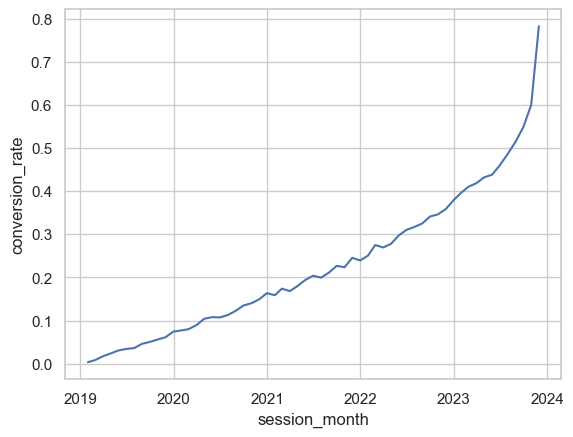

In [343]:
sns.lineplot(x="session_month", y="conversion_rate",data=monthly_conversion_rate)

In [344]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_month
    ,traffic_source
    ,COUNT(CASE WHEN ending_event = 'purchase' THEN session_id ELSE NULL END) AS num_purchases
    ,COUNT(*) AS num_sessions
FROM
    session_metrics
GROUP BY
    session_month
    ,traffic_source
ORDER BY
    session_month
    ,traffic_source
"""
monthly_conversion_rate_agg = pandas_gbq.read_gbq(query)
monthly_conversion_rate_agg['conversion_rate'] = monthly_conversion_rate_agg['num_purchases'] * 1.0 / monthly_conversion_rate_agg['num_sessions'] * 1.0
monthly_conversion_rate_agg.head()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_month,traffic_source,num_purchases,num_sessions,conversion_rate
0,2019-01-31,Adwords,13,2587,0.005025
1,2019-01-31,Email,11,3765,0.002922
2,2019-01-31,Facebook,1,852,0.001174
3,2019-01-31,Organic,1,422,0.00237
4,2019-01-31,YouTube,2,794,0.002519


<Axes: xlabel='session_month', ylabel='conversion_rate'>

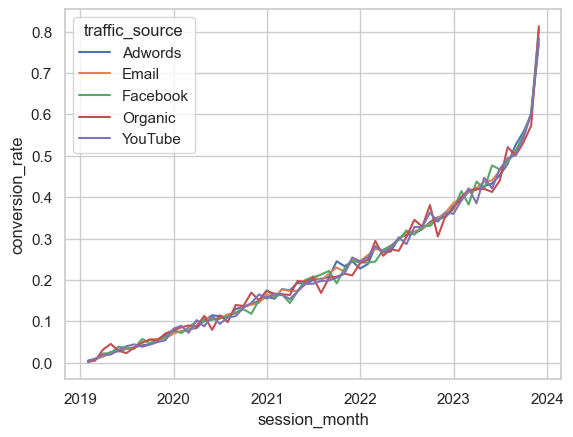

In [345]:
sns.lineplot(x="session_month", y="conversion_rate",hue="traffic_source",data=monthly_conversion_rate_agg)

In [388]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(created_at) AS session_start
    ,MAX(created_at) AS session_end
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,DATETIME_DIFF(session_end,session_start,MINUTE) AS session_length_minutes
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_metrics.session_id
    ,session_metrics.user_id
    ,session_metrics.is_customer
    ,session_metrics.session_month
    ,session_metrics.session_start_date
    ,session_metrics.session_end_date
    ,session_metrics.session_length_minutes
    ,session_metrics.same_day_session
    ,session_metrics.browser
    ,session_metrics.traffic_source
    ,session_metrics.starting_event
    ,COALESCE(session_metrics.ending_event,session_metrics.starting_event) AS ending_event
FROM
    session_metrics
"""
session_details = pandas_gbq.read_gbq(query)
session_details.head()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,session_length_minutes,same_day_session,browser,traffic_source,starting_event,ending_event
0,788efe88-2584-40c2-88be-aa040ccdb368,<NA>,False,2019-06-30,2019-06-08,2019-06-08,29,True,Firefox,Email,department,cart
1,70517599-359e-4858-8a0c-a073efcd3ba0,<NA>,False,2019-08-31,2019-08-12,2019-08-12,32,True,Safari,Email,department,cart
2,b856d728-08cd-44d3-836c-fa2f9226e61f,<NA>,False,2023-06-30,2023-06-21,2023-06-21,39,True,Chrome,Email,department,cart
3,af3dfb27-2962-4ea3-8b65-609aff59aa06,<NA>,False,2019-02-28,2019-02-27,2019-02-27,54,True,Chrome,Email,department,cart
4,1d516474-ffc1-4780-b681-c03ba34e801f,<NA>,False,2019-07-31,2019-07-06,2019-07-06,13,True,Chrome,Email,department,cart


In [389]:
session_details.query("is_customer==True").groupby('user_id').nunique().reset_index().query("session_id > 1").sort_values('session_id',ascending=False)

,user_id,session_id,is_customer,session_month,session_start_date,session_end_date,session_length_minutes,same_day_session,browser,traffic_source,starting_event,ending_event
79065,98695,13,1,3,4,10,13,2,5,3,1,1
9357,11722,13,1,1,3,5,11,2,3,3,2,1
3332,4186,13,1,4,4,10,13,2,3,4,2,1
10770,13445,13,1,4,8,12,11,1,3,4,1,1
43291,53938,13,1,4,4,11,12,2,2,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
37261,46409,2,1,2,2,2,2,1,2,1,1,1
37258,46405,2,1,1,1,2,2,2,1,1,1,1
37257,46404,2,1,2,2,2,1,1,2,2,1,1
37253,46398,2,1,1,1,1,2,1,2,2,1,1


In [390]:
session_sources_by_month = session_details.groupby(['is_customer','session_month','traffic_source'])[['session_id']].count().reset_index()

In [391]:
session_sources = session_details.groupby(['is_customer','traffic_source'])[['session_id']].count().reset_index()

In [392]:
session_sources

,is_customer,traffic_source,session_id
0,False,Adwords,149812
1,False,Email,224707
2,False,Facebook,50045
3,False,Organic,25144
4,False,YouTube,50292
5,True,Adwords,54475
6,True,Email,82244
7,True,Facebook,18207
8,True,Organic,9016
9,True,YouTube,18071


In [393]:
54320/(54320+149785)

0.2661375272531295

In [352]:
81773/(225683+81773)

0.26596651228143214

In [353]:
17847/(49881+17847)

0.2635099220411056

In [354]:
9103/(9103+24868)

0.26796385152041446

In [355]:
18127/(18127+49783)

0.26692681490207626

In [394]:
session_ending_event_summary = session_details.groupby(['is_customer','ending_event'])[['session_id']].count().reset_index()
session_ending_event_summary

,is_customer,ending_event,session_id
0,False,cancel,125229
1,False,cart,125119
2,False,product,249652
3,True,purchase,182013


<Axes: xlabel='traffic_source', ylabel='session_id'>

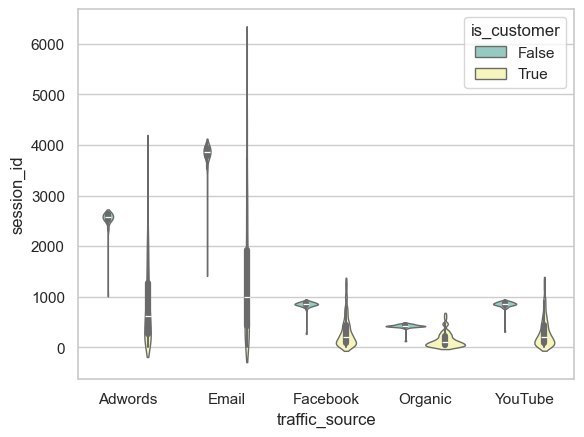

In [395]:
sns.violinplot(data=session_sources_by_month,x='traffic_source', y='session_id', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

<Axes: xlabel='is_customer', ylabel='session_length_minutes'>

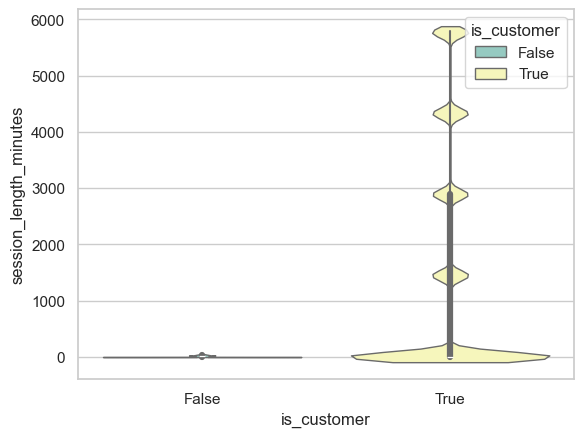

In [412]:
sns.violinplot(data=df,x='is_customer', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

In [423]:
df2 = df.groupby('state').count().reset_index()
df2.sort_values('session_id',ascending=False).head(50)

,state,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,user_traffic_sources,city
67,Guangdong,36382,9527,36382,36382,36382,36382,36382,36382,36382,36382,36382,36382,9527,9527,9527,9527,36382
52,England,27660,7288,27660,27660,27660,27660,27660,27660,27660,27660,27660,27660,7288,7288,7288,7288,27660
28,California,25459,6874,25459,25459,25459,25459,25459,25459,25459,25459,25459,25459,6874,6874,6874,6874,25459
204,Texas,16864,4565,16864,16864,16864,16864,16864,16864,16864,16864,16864,16864,4565,4565,4565,4565,16864
192,Shanghai,16558,4485,16558,16558,16558,16558,16558,16558,16558,16558,16558,16558,4485,4485,4485,4485,16558
201,São Paulo,14664,3883,14664,14664,14664,14664,14664,14664,14664,14664,14664,14664,3883,3883,3883,3883,14664
229,Zhejiang,14323,3896,14323,14323,14323,14323,14323,14323,14323,14323,14323,14323,3896,3896,3896,3896,14323
20,Beijing,14266,3960,14266,14266,14266,14266,14266,14266,14266,14266,14266,14266,3960,3960,3960,3960,14266
79,Hebei,13324,3524,13324,13324,13324,13324,13324,13324,13324,13324,13324,13324,3524,3524,3524,3524,13324
100,Jiangsu,12494,3314,12494,12494,12494,12494,12494,12494,12494,12494,12494,12494,3314,3314,3314,3314,12494


Advertise on Instagram, TikTok


In [88]:
681170 * 2

1362340

In [398]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(created_at) AS session_start
    ,MAX(created_at) AS session_end
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,DATETIME_DIFF(session_end,session_start,MINUTE) AS session_length_minutes
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
    ,events.city
    ,events.state
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,city
    ,state
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,city
    ,state
),
users AS (
SELECT
    id
    ,age
    ,gender
    ,country
    ,traffic_source
FROM
    `trumid-case.thelook_ecommerce.users`
),
user_sessions AS (
SELECT
    session_metrics.session_id
    ,session_metrics.user_id
    ,session_metrics.is_customer
    ,session_metrics.session_month
    ,session_metrics.session_start_date
    ,session_metrics.session_end_date
    ,session_metrics.same_day_session
    ,session_metrics.browser
    ,session_metrics.traffic_source
    ,session_metrics.starting_event
    ,COALESCE(session_metrics.ending_event,session_metrics.starting_event) AS ending_event
    ,session_metrics.session_length_minutes
    ,users.age
    ,users.gender
    ,users.country
    ,users.traffic_source AS user_traffic_sources
    ,session_metrics.city
    ,session_metrics.state
FROM
    session_metrics
LEFT JOIN
    users
ON
    session_metrics.user_id = users.id
)
SELECT
    *
FROM
    user_sessions
"""
df = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [399]:
df

,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,user_traffic_sources,city,state
0,301e0493-6dda-4cec-9d9d-e243979a46ff,84397,True,2023-10-31,2023-10-26,2023-10-26,True,IE,Email,home,purchase,6,16,M,Brasil,Search,Itabirito,Minas Gerais
1,c80a5712-70f6-440d-b378-ee3313d0b10a,51705,True,2021-03-31,2021-03-13,2021-03-16,False,Chrome,Adwords,department,purchase,4334,39,F,Brasil,Search,Brumadinho,Minas Gerais
2,a6f90a5c-dbeb-4a86-b10c-43e059807932,15488,True,2022-04-30,2022-04-25,2022-04-25,True,Chrome,Adwords,home,purchase,10,12,F,Brasil,Search,Bom Despacho,Minas Gerais
3,6a053482-c66f-4a62-9949-6d2c482e076e,78312,True,2023-10-31,2023-10-20,2023-10-23,False,Firefox,Email,department,purchase,4336,54,F,Brasil,Search,Congonhas,Minas Gerais
4,50f1cbc4-7021-4341-a56a-ba2974148aac,12518,True,2019-07-31,2019-07-09,2019-07-11,False,Safari,YouTube,department,purchase,2901,40,M,Brasil,Search,Ubá,Minas Gerais
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682008,4009aa89-0e51-432e-a21c-23171aaa71fd,49803,True,2023-01-31,2023-01-09,2023-01-12,False,Firefox,Adwords,department,purchase,4327,17,M,Brasil,Search,São Paulo,São Paulo
682009,0b9b4dcb-ce6e-4b4a-a655-a4bd7bf31743,52901,True,2021-02-28,2021-02-07,2021-02-11,False,Chrome,Email,department,purchase,5766,49,F,Brasil,Search,Embu-Guaçu,São Paulo
682010,43c65ad5-2054-43c9-90c6-b3e3a4deb049,99487,True,2022-05-31,2022-05-01,2022-05-01,True,Safari,YouTube,department,purchase,8,55,F,Brasil,Search,Artur Nogueira,São Paulo
682011,dd2f8af1-a30d-4d4c-8157-9d9e6a1dec76,25385,True,2023-08-31,2023-08-08,2023-08-09,False,IE,YouTube,department,purchase,1451,25,M,Brasil,Organic,Lavras,Minas Gerais


In [401]:
df.query("session_length_minutes > 5000")

,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,user_traffic_sources,city,state
16,761a644e-97a1-4578-9872-5d45ce96737e,88964,True,2022-04-30,2022-03-30,2022-04-03,False,Chrome,Adwords,department,purchase,5774,48,F,Brasil,Organic,Salvador,Bahia
23,a44547da-f9bc-4bbc-8730-5c88f4f2a90a,51233,True,2023-07-31,2023-07-01,2023-07-05,False,Chrome,Email,department,purchase,5767,32,M,Brasil,Search,Barra,Bahia
42,b85ed94a-4ff6-446d-aaac-1fe2c7329153,18413,True,2023-08-31,2023-07-31,2023-08-04,False,Chrome,Facebook,department,purchase,5767,53,F,Brasil,Search,Parnamirim,Rio Grande do Norte
50,c30c8915-420a-41f6-b9ea-af777db4843a,27495,True,2023-07-31,2023-07-14,2023-07-18,False,Chrome,Adwords,department,purchase,5773,34,F,Brasil,Search,Crateús,Ceará
53,3ee9983f-429e-4806-a2d8-9da07ec7bb77,88175,True,2022-05-31,2022-05-19,2022-05-23,False,Safari,Adwords,department,purchase,5768,62,M,Brasil,Search,Picos,Piauí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681988,714a4061-9a62-4d5a-abd0-3e55910e08b2,38575,True,2023-09-30,2023-09-22,2023-09-26,False,Chrome,Adwords,department,purchase,5769,49,M,China,Search,Haixi Mongolian Tibetan Autonomous Prefecture,Liaoning
681991,60c5ecdc-1e74-4aa4-bf01-c085af487663,98749,True,2022-09-30,2022-09-14,2022-09-18,False,Chrome,Adwords,department,purchase,5769,50,F,China,Search,Dongguan,Tianjin
681998,a26f63b1-591f-4799-b7dc-ba8e8675abfc,14906,True,2021-12-31,2021-12-08,2021-12-12,False,Safari,YouTube,department,purchase,5768,12,F,China,Display,Shanghai,Guangdong
681999,0d28088c-e29c-4faa-b331-4588bd78d019,49663,True,2020-09-30,2020-09-12,2020-09-16,False,Chrome,Facebook,department,purchase,5769,24,M,China,Organic,Hengyang,Guangdong


In [403]:
df.head()

,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,user_traffic_sources,city,state
0,301e0493-6dda-4cec-9d9d-e243979a46ff,84397,True,2023-10-31,2023-10-26,2023-10-26,True,IE,Email,home,purchase,6,16,M,Brasil,Search,Itabirito,Minas Gerais
1,c80a5712-70f6-440d-b378-ee3313d0b10a,51705,True,2021-03-31,2021-03-13,2021-03-16,False,Chrome,Adwords,department,purchase,4334,39,F,Brasil,Search,Brumadinho,Minas Gerais
2,a6f90a5c-dbeb-4a86-b10c-43e059807932,15488,True,2022-04-30,2022-04-25,2022-04-25,True,Chrome,Adwords,home,purchase,10,12,F,Brasil,Search,Bom Despacho,Minas Gerais
3,6a053482-c66f-4a62-9949-6d2c482e076e,78312,True,2023-10-31,2023-10-20,2023-10-23,False,Firefox,Email,department,purchase,4336,54,F,Brasil,Search,Congonhas,Minas Gerais
4,50f1cbc4-7021-4341-a56a-ba2974148aac,12518,True,2019-07-31,2019-07-09,2019-07-11,False,Safari,YouTube,department,purchase,2901,40,M,Brasil,Search,Ubá,Minas Gerais


In [363]:
len(user_event_detail)

682013

In [ ]:
user_event_detail.country(''

<Axes: xlabel='traffic_source', ylabel='session_length_minutes'>

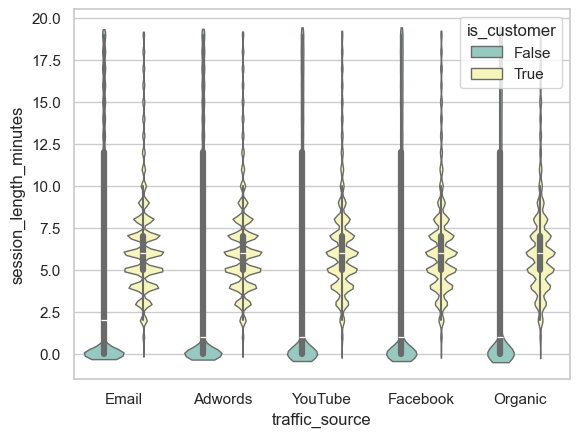

In [404]:
sns.violinplot(data=df.query("session_length_minutes < 20"),x='traffic_source', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

<Axes: xlabel='traffic_source', ylabel='session_length_minutes'>

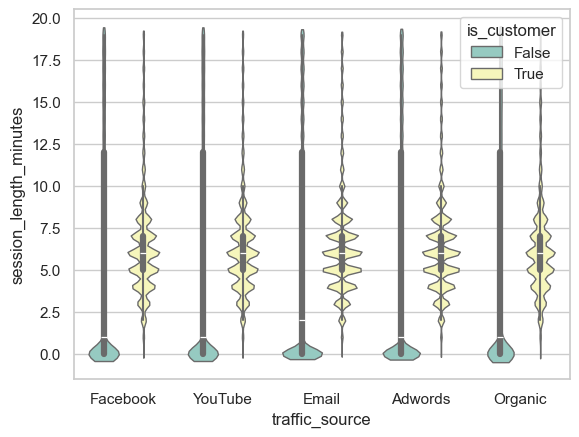

In [368]:
sns.violinplot(data=user_event_detail.query("session_length_minutes < 20"),x='traffic_source', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

<Axes: xlabel='traffic_source', ylabel='session_length_minutes'>

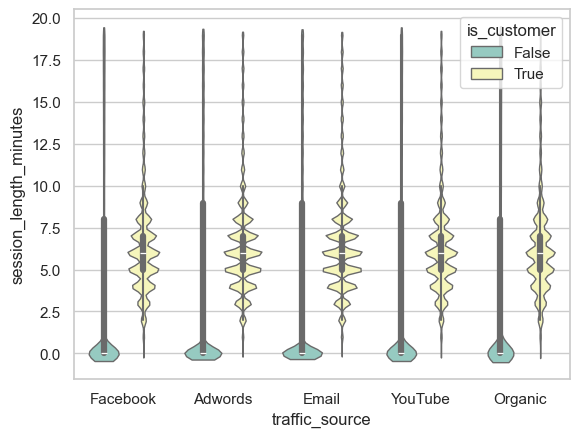

In [374]:
sns.violinplot(data=user_event_detail.query("session_length_minutes < 20 & ending_event != 'product'"),x='traffic_source', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

In [407]:
df.query("session_length_minutes < 20 & ending_event != 'product' & ending_event != 'purchase'")

,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,user_traffic_sources,city,state
139,22a9ae61-84fc-4d29-bf3d-5044f68820e4,<NA>,False,2020-06-30,2020-06-29,2020-06-29,True,Firefox,Adwords,department,cart,4,<NA>,None,None,None,Żagań,Lubuskie
141,8d8f4bdb-ea0a-4fa8-964c-d665bcff1933,<NA>,False,2023-05-31,2023-05-01,2023-05-01,True,Firefox,YouTube,department,cart,4,<NA>,None,None,None,London,England
153,102bbb65-bb4a-4f84-92f4-ce2f847d17a7,<NA>,False,2021-05-31,2021-05-29,2021-05-29,True,IE,YouTube,department,cart,16,<NA>,None,None,None,Dundee,Scotland
165,1e81e765-6718-4098-94e8-627130027afb,<NA>,False,2020-11-30,2020-11-18,2020-11-18,True,Chrome,YouTube,department,cart,10,<NA>,None,None,None,Ilford,England
220,eeec286a-6169-4790-a5c3-a9405ff757ba,<NA>,False,2022-08-31,2022-08-14,2022-08-14,True,Firefox,YouTube,department,cart,17,<NA>,None,None,None,Newcastle,New South Wales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680990,2f13faf9-5047-44b6-9a36-e74eb2934fc3,<NA>,False,2019-07-31,2019-07-27,2019-07-27,True,Firefox,Facebook,product,cancel,13,<NA>,None,None,None,Nova Odessa,São Paulo
680991,4a8e63e1-3b0c-4ba8-acfe-210786b729f7,<NA>,False,2023-09-30,2023-09-29,2023-09-29,True,Chrome,YouTube,product,cancel,19,<NA>,None,None,None,Maricá,Rio de Janeiro
680993,da0c6e5b-7c43-4515-af5b-5ef1591c242e,<NA>,False,2022-08-31,2022-08-12,2022-08-12,True,Firefox,Adwords,product,cancel,14,<NA>,None,None,None,Eunápolis,Bahia
680994,6ae937f1-2c42-427d-8b7a-30ab323e419f,<NA>,False,2021-05-31,2021-05-10,2021-05-10,True,Chrome,Facebook,product,cancel,19,<NA>,None,None,None,null,Pará


In [ ]:
sns.violinplot(data=user_event_detail.query("session_length_minutes < 20"),x='traffic_source', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

In [306]:
user_event_detail.query("is_customer == True").shape

(182013, 18)

In [307]:
92636/182013

0.5089526572277804

In [308]:
user_event_detail.query("session_length_minutes <= 10 & is_customer == False").shape

(188815, 18)

In [309]:
user_event_detail.query("session_length_minutes <= 10 & is_customer == True").shape

(96501, 18)

In [310]:
user_event_detail.query("session_length_minutes <= 10 & session_length_minutes > 2 & is_customer == True").shape

(92636, 18)

In [311]:
user_event_detail.query("session_length_minutes <= 2 & is_customer == True").shape

(3865, 18)

In [312]:
user_event_detail.query("session_length_minutes <= 2 & is_customer == False").shape

(138688, 18)

In [313]:
user_event_detail.query("session_length_minutes <= 2 & is_customer == False").groupby(['ending_event'])[['session_id']].count().reset_index()

,ending_event,session_id
0,cancel,823
1,cart,822
2,product,12574


In [408]:
df.query("session_length_minutes <= 2 & is_customer == False").groupby(['ending_event'])[['session_id']].count().reset_index()

,ending_event,session_id
0,cancel,823
1,cart,822
2,product,137043


In [410]:
df.query("is_customer == False").groupby(['ending_event'])[['session_id']].count().reset_index()

,ending_event,session_id
0,cancel,125229
1,cart,125119
2,product,249652


In [328]:
user_event_detail.query("is_customer==True").head()

,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,same_day_session,browser,traffic_source,starting_event,ending_event,session_length_minutes,age,gender,country,traffic_source_1,city,state
2,1a2b5687-3383-4dac-800a-e94cf8b10cfc,55235,True,2023-03-31,2023-03-27,2023-03-30,False,Safari,Facebook,department,purchase,4327,65,F,China,Search,Chengdu,Tianjin
5,fe844050-57d5-4f4d-b272-aa67da5c4eb4,98660,True,2021-01-31,2021-01-03,2021-01-04,False,Chrome,Adwords,department,purchase,1454,65,F,China,Search,Beijing,Tianjin
6,1abe9cf8-9bdf-4aaa-b6c6-9da0197cfea1,9119,True,2023-08-31,2023-08-12,2023-08-14,False,Chrome,Adwords,department,purchase,2889,69,F,China,Search,Huaibei,Tianjin
10,e1bb5011-7e20-4ab1-ba6c-c0f7adcdc054,43615,True,2023-02-28,2023-02-08,2023-02-11,False,Safari,Adwords,department,purchase,4333,33,F,China,Search,Zhengzhou,Tianjin
16,ccb07b38-25d1-479b-bf10-d9f43efffef2,77496,True,2020-12-31,2020-12-09,2020-12-10,False,Safari,Email,department,purchase,1450,28,M,China,Search,Shanghai,Zhejiang


In [317]:
# Total
query = """
SELECT
    num_purchase_sessions
    ,num_sessions
    ,(num_purchase_sessions * 1.0) / (num_sessions * 1.0) AS conversion_rate
FROM
(
    SELECT
        count(distinct session_id) as num_sessions
        ,count(distinct case when event_type = 'purchase' then session_id else null end) as num_purchase_sessions
    FROM
         `trumid-case.thelook_ecommerce.events`
 )
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_purchase_sessions,num_sessions,conversion_rate
0,182013,682013,0.266876


In [221]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'purchase' then session_id else null end) as num_cancel_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE 
    user_id IS NOT NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_cancel_sessions
0,181028,181028


In [220]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'cancel' then session_id else null end) as num_cancel_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE 
    user_id IS NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_cancel_sessions
0,500000,124677


In [318]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    session_id,
    max(sequence_number)
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY 1
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_id,f0_
0,409d22de-65f3-4ac0-8597-67e20b2e6ce6,1
1,bc835024-4231-4d9c-a6fa-b6819b621eb6,1
2,066fdacb-5471-45ac-bb29-1e45ac9c2864,1
3,3c4f0db2-b02a-4066-a197-b2dfaadd31b7,1
4,7aae1931-ad2b-4ec4-94af-598a22227dc1,1
...,...,...
682008,4e8c2b72-3d5e-4634-a139-3dd8b581d7ab,13
682009,2d0356da-a23c-4cbc-b2db-089463747162,13
682010,a51df6e5-5d8d-4c41-b59f-f92e25d20e84,13
682011,b0d327b2-04e4-426f-a3d4-fc4b85154ca1,13


In [378]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    session_id = '6d468526-983f-434a-8a5d-18850acc8e1d'
    --'4e8c2b72-3d5e-4634-a139-3dd8b581d7ab'
ORDER BY
    sequence_number
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1956157,<NA>,1,6d468526-983f-434a-8a5d-18850acc8e1d,2020-01-25 13:31:00+00:00,6.129.133.76,Campinas,São Paulo,13061-155,Firefox,Facebook,/product/25507,product


In [370]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.products`
WHERE
    id = 3311
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,3311,15.98958,Dresses,Patty Women Convertible V Neck / One Shoulder ...,Patty,37.98,Women,BDD8817990EF209F0FB6B049F2D2EA0C,1


In [330]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    event_type,
    COUNT(*)
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    sequence_number = 1
GROUP BY 1
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type,f0_
0,home,87692
1,product,249698
2,department,344623


conversion rate = number of sessions that end in a purchase
181028/681028

* Can look at among registered users what differs between successful and unsuccessful purchases
  * Where does the funnel breakdown?
* Can look for similarities among unsuccessful without user id (brand, product, location)

In [ ]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
) -- JOIN TO PRODUCTS TO SEE WHAT'S BEING DESERTED
"""
monthly_conversion_rate_agg = pandas_gbq.read_gbq(query)
monthly_conversion_rate_agg['conversion_rate'] = monthly_conversion_rate_agg['num_purchases'] * 1.0 / monthly_conversion_rate_agg['num_sessions'] * 1.0
monthly_conversion_rate_agg.head()

# Question 3

In [180]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,CASE
        WHEN order_item_shipped_at IS NOT NULL
        THEN DATE_DIFF(order_item_shipped_at,order_created_at,DAY) 
        ELSE NULL END AS order_to_ship
    ,CASE 
        WHEN order_item_delivered_at IS NOT NULL
        THEN DATE_DIFF(order_item_delivered_at,order_item_shipped_at,DAY)
        ELSE NULL END AS ship_to_deliver
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL
        THEN DATE_DIFF(order_item_returned_at,order_item_delivered_at,DAY)
        ELSE NULL END AS deliver_to_return
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
/*
WHERE
    order_item_status IN ('Complete','Returned')
*/
),
thelook_agg_return_metrics AS (
SELECT
    is_returned
    ,order_item_id
    ,product_category
    ,product_distribution_center_id
    ,product_brand
    ,product_name
    ,product_department
    ,ship_to_deliver
    ,order_to_ship
    ,order_to_ship + ship_to_deliver AS order_to_deliver
    /*
    ,COUNT(order_item_id) AS quantity
    ,MIN(order_to_ship) AS fastest_ship
    ,AVG(order_to_ship) AS average_ship
    ,MAX(order_to_ship) AS slowest_ship
    ,MIN(ship_to_deliver) AS fastest_delivery
    ,AVG(ship_to_deliver) AS average_delivery
    ,MAX(ship_to_deliver) AS slowest_delivery
    ,MIN(deliver_to_return) AS fastest_return
    ,AVG(deliver_to_return) AS average_return
    ,MAX(deliver_to_return) AS slowest_return
    */
FROM
    thelook_return_metrics
/*
GROUP BY
    is_returned
    ,order_item_id
    --,product_category
    ,product_distribution_center_id
    --,product_brand
    --,product_name
    --,product_department
ORDER BY
    is_returned
*/
)
SELECT * FROM thelook_agg_return_metrics
"""
return_metrics = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [181]:
return_metrics.query("is_returned == True")

,is_returned,order_item_id,product_category,product_distribution_center_id,product_brand,product_name,product_department,ship_to_deliver,order_to_ship,order_to_deliver
19,True,10866,Jumpsuits & Rompers,7,FineBrandShop,Ladies Red White Geometric Strapless Jumper,Women,1,2,3
20,True,76680,Jumpsuits & Rompers,7,FineBrandShop,Ladies Red White Geometric Strapless Jumper,Women,0,1,1
21,True,98204,Jumpsuits & Rompers,7,FineBrandShop,Ladies Yellow White Geometric Strapless Jumper,Women,4,1,5
49,True,91489,Jumpsuits & Rompers,9,Cheap Monday,Cheap Monday Womens Angel Jumpsuit,Women,1,1,2
67,True,12612,Jumpsuits & Rompers,8,American Apparel,American Apparel Chambray Jumpsuit,Women,3,0,3
...,...,...,...,...,...,...,...,...,...,...
180745,True,8837,Fashion Hoodies & Sweatshirts,6,Next Level,6021 Next Level Men's Tri-Blend Long-Sleeve Ho...,Men,4,2,6
180746,True,90476,Fashion Hoodies & Sweatshirts,6,Next Level,6021 Next Level Men's Tri-Blend Long-Sleeve Ho...,Men,1,1,2
180761,True,147107,Fashion Hoodies & Sweatshirts,8,Famous Stars and Straps,Famous Stars and Straps Men's Parallesl Zip Ho...,Men,2,0,2
180784,True,27689,Fashion Hoodies & Sweatshirts,9,Allegra K,Allegra K Ladies Long Sleeve Panda Pattern Kan...,Women,0,1,1


In [182]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
SELECT
    status
    ,COUNT(*) AS totalcount
FROM
    `trumid-case.thelook_ecommerce.order_items` 
GROUP BY
    status
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████|


,status,totalcount
0,Shipped,54522
1,Complete,45246
2,Processing,36063
3,Returned,18088
4,Cancelled,26879


([0, 1], [Text(0, 0, 'False'), Text(1, 0, 'True')])

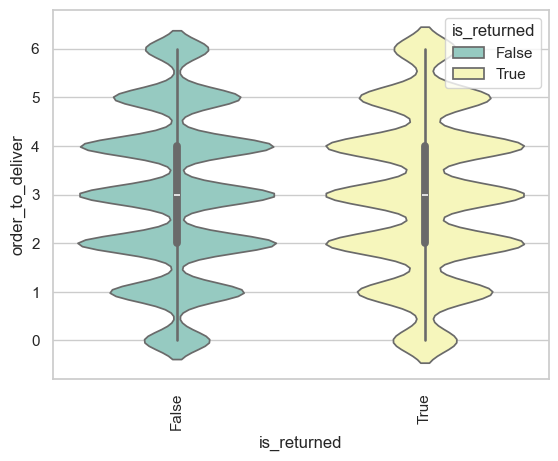

In [183]:
sns.violinplot(data=return_metrics, x='is_returned', y='order_to_deliver',hue='is_returned',palette="Set3")
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

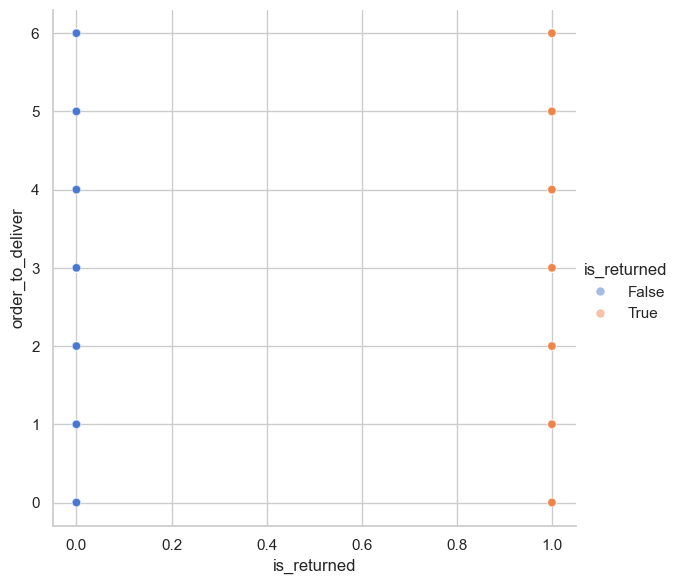

In [153]:
sns.relplot(x="is_returned", y="order_to_deliver", hue="is_returned",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=return_metrics)

In [175]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
    ,users.gender AS user_gender
    ,users.country AS user_country
    ,users.age AS user_age
    ,
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,user_gender
    ,user_country
    ,user_age
    ,CASE
        WHEN order_item_shipped_at IS NOT NULL
        THEN DATE_DIFF(order_item_shipped_at,order_created_at,DAY) 
        ELSE NULL END AS order_to_ship
    ,CASE 
        WHEN order_item_delivered_at IS NOT NULL
        THEN DATE_DIFF(order_item_delivered_at,order_item_shipped_at,DAY)
        ELSE NULL END AS ship_to_deliver
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL
        THEN DATE_DIFF(order_item_returned_at,order_item_delivered_at,DAY)
        ELSE NULL END AS deliver_to_return
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
WHERE
    order_item_status IN ('Complete','Returned')
),
thelook_agg_return_metrics AS (
SELECT
    is_returned
    ,user_age
    ,COUNT(order_item_id) AS quantity
    ,MIN(order_to_ship) AS fastest_ship
    ,AVG(order_to_ship) AS average_ship
    ,MAX(order_to_ship) AS slowest_ship
    ,MIN(ship_to_deliver) AS fastest_delivery
    ,AVG(ship_to_deliver) AS average_delivery
    ,MAX(ship_to_deliver) AS slowest_delivery
    ,MIN(deliver_to_return) AS fastest_return
    ,AVG(deliver_to_return) AS average_return
    ,MAX(deliver_to_return) AS slowest_return
FROM
    thelook_return_metrics
GROUP BY
    is_returned
    ,user_age
)
SELECT * FROM thelook_agg_return_metrics
ORDER BY is_returned DESC
"""
country = pandas_gbq.read_gbq(query)
country.query("is_returned == True").sort_values('quantity',ascending=False)

Downloading: 100%|█████████████████████████████████████████████████████████████|


,is_returned,user_age,quantity,fastest_ship,average_ship,slowest_ship,fastest_delivery,average_delivery,slowest_delivery,fastest_return,average_return,slowest_return
14,True,33,366,0,0.877049,2,0,1.986339,4,0,0.997268,2
17,True,18,363,0,1.063361,2,0,2.019284,4,0,1.016529,2
21,True,58,360,0,0.955556,2,0,2.091667,4,0,1.119444,2
54,True,37,356,0,0.957865,2,0,1.997191,4,0,0.896067,2
43,True,40,354,0,1.036723,2,0,1.926554,4,0,1.000000,2
18,True,69,353,0,0.985836,2,0,1.852691,4,0,1.022663,2
26,True,67,343,0,1.023324,2,0,1.845481,4,0,1.011662,2
19,True,31,335,0,1.014925,2,0,1.967164,4,0,1.056716,2
8,True,66,332,0,0.933735,2,0,2.069277,4,0,1.063253,2
56,True,30,329,0,0.945289,2,0,2.018237,4,0,1.015198,2


In [173]:
pd.melt(country[['is_returned','user_country','quantity']], id_vars =['is_returned','user_country'], value_vars =['quantity']).sort_values('user_country')

KeyError: "['user_country'] not in index"

In [245]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
    ,users.gender AS user_gender
    ,users.country AS user_country
    ,users.age AS user_age
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,user_gender
    ,user_country
    ,user_age
    ,CASE WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
WHERE
    order_item_status IN ('Complete', 'Returned')
),
thelook_agg_return_metrics AS (
SELECT
    product_department
    ,product_category
    ,COUNT(CASE WHEN is_returned IS TRUE THEN order_item_id ELSE NULL END) AS num_returns
    ,COUNT(CASE WHEN is_returned IS FALSE THEN order_item_id ELSE NULL END) AS num_completed
    ,COUNT(order_item_id) AS total
FROM
    thelook_return_metrics
GROUP BY
    product_department
    ,product_category
)
SELECT
    * 
    --,LEFT(CAST(user_age AS STRING),1) AS decade
    ,(num_returns * 1.0) / (total * 1.0) AS return_rate
FROM 
    thelook_agg_return_metrics
"""
users = pandas_gbq.read_gbq(query)
users.sort_values('return_rate',ascending=False)#.query("return_rate > 0 & return_rate < 1")

Downloading: 100%|█████████████████████████████████████████████████████████████|


,product_department,product_category,num_returns,num_completed,total,return_rate
11,Women,Skirts,226,506,732,0.308743
8,Women,Leggings,345,774,1119,0.308311
0,Women,Accessories,446,1025,1471,0.303195
6,Women,Socks & Hosiery,420,975,1395,0.301075
22,Women,Swim,530,1238,1768,0.299774
7,Men,Active,527,1241,1768,0.298077
18,Women,Sleep & Lounge,487,1153,1640,0.296951
19,Women,Jeans,528,1270,1798,0.293660
31,Men,Fashion Hoodies & Sweatshirts,708,1703,2411,0.293654
5,Men,Tops & Tees,734,1794,2528,0.290348


/var/folders/w8/8ywl8kgs1dj17b9910td3z440000gn/T/ipykernel_96692/1979230609.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(x="product_department", y="return_rate",


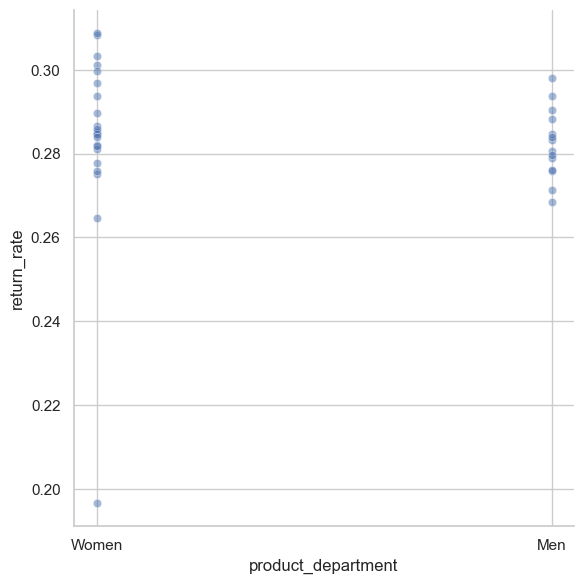

In [243]:
sns.relplot(x="product_department", y="return_rate",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=users)

([0, 1], [Text(0, 0, 'Women'), Text(1, 0, 'Men')])

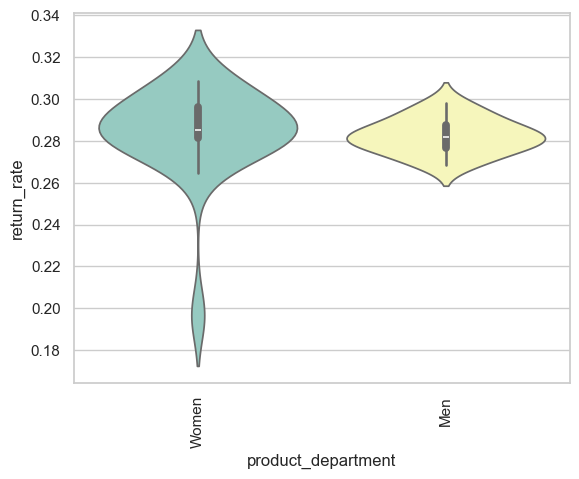

In [244]:
sns.violinplot(data=users, x='product_department', y='return_rate',hue = 'product_department', palette="Set3")
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [303]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
aov_aop_sql = """
WITH thelook_order_details AS (
SELECT
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status AS order_status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)] as domain
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at) AS order_date
    ,CASE WHEN orders.status = 'Returned' THEN TRUE ELSE FALSE END AS is_return
    ,SUM(order_items.sale_price) AS order_revenue
    ,COUNT(order_items.id) AS num_items
FROM
    `trumid-case.thelook_ecommerce.orders`  AS orders
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items` AS order_items
ON
    orders.order_id = order_items.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users`  AS users
ON
    orders.user_id = users.id
GROUP BY
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)]
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at)
),
completed_returned_only AS (
SELECT
    *
    ,EXTRACT(MONTH FROM order_date) AS order_month
    ,EXTRACT(YEAR FROM order_date) AS order_year
    ,CAST(EXTRACT(YEAR FROM order_date) AS STRING)||'-'||CAST(EXTRACT(MONTH FROM order_date) AS STRING) AS year_month
FROM 
    thelook_order_details
WHERE
    order_status IN ('Complete', 'Returned')
)
SELECT
    is_return
    ,year_month
    ,COUNT(order_id) AS num_orders
    ,AVG(order_revenue) AS average_order_value
    ,SUM(num_of_item) AS item_count_prog
    ,SUM(num_items) AS item_count_man 
FROM 
    completed_returned_only
GROUP BY
    is_return
    ,year_month
"""
aov_aop = pandas_gbq.read_gbq(aov_aop_sql)
aov_aop = aov_aop.query("is_return == True")

Downloading: 100%|█████████████████████████████████████████████████████████████|


/var/folders/w8/8ywl8kgs1dj17b9910td3z440000gn/T/ipykernel_96692/291788650.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=aov_aop, x='year_month', y='average_order_value', palette="Set3")


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58],
 [Text(0, 0, '2023-7'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-3'),
  Text(3, 0, '2022-11'),
  Text(4, 0, '2021-12'),
  Text(5, 0, '2023-8'),
  Text(6, 0, '2022-12'),
  Text(7, 0, '2023-9'),
  Text(8, 0, '2023-5'),
  Text(9, 0, '2022-3'),
  Text(10, 0, '2022-7'),
  Text(11, 0, '2020-5'),
  Text(12, 0, '2023-6'),
  Text(13, 0, '2020-12'),
  Text(14, 0, '2022-2'),
  Text(15, 0, '2022-5'),
  Text(16, 0, '2022-6'),
  Text(17, 0, '2020-3'),
  Text(18, 0, '2022-10'),
  Text(19, 0, '2020-8'),
  Text(20, 0, '2023-1'),
  Text(21, 0, '2022-8'),
  Text(22, 0, '2020-6'),
  Text(23, 0, '2020-10'),
  Text(24, 0, '2021-6'),
  Text(25, 0, '2021-9'),
  Text(2

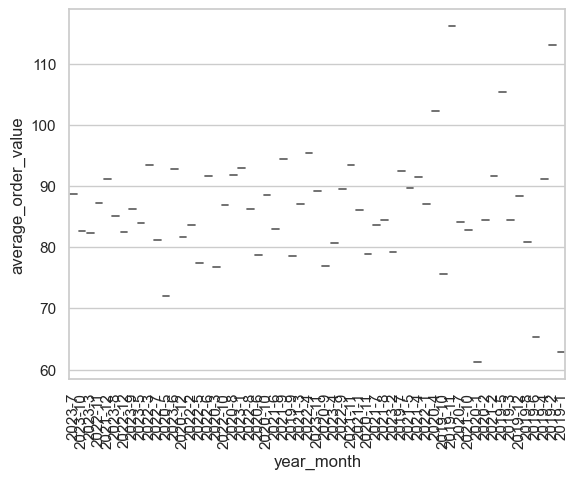

In [305]:
sns.violinplot(data=aov_aop, x='year_month', y='average_order_value', palette="Set3")
# Rotate x-axis labels for better readability (optional)d
plt.xticks(rotation=90)

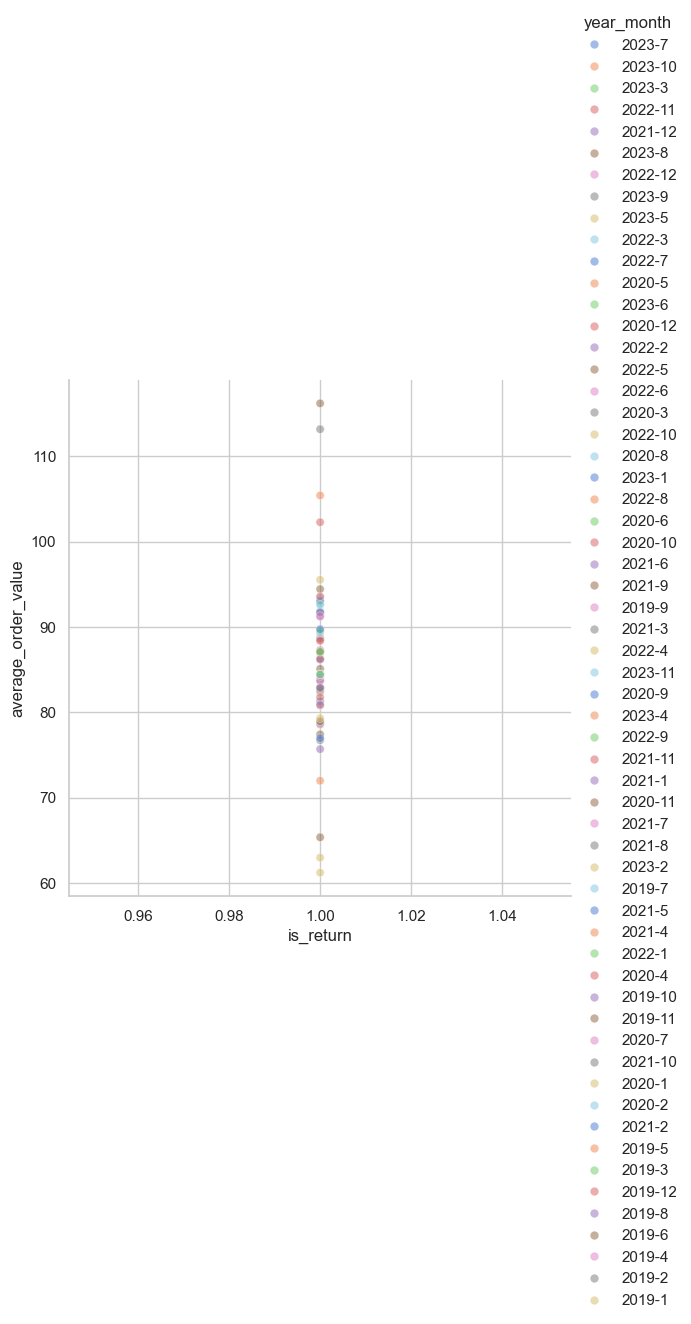

In [306]:
sns.relplot(x="is_return", y="average_order_value", hue ='year_month',
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=aov_aop)

In [300]:
aov_aop

,is_return,year_month,num_orders,average_order_value,item_count_prog,item_count_man
0,False,2023-9,1880,83.247399,2701,2701
1,False,2022-4,598,84.694231,876,876
2,False,2023-10,2422,89.671784,3571,3571
3,False,2020-6,185,91.266757,278,278
4,False,2023-8,1660,86.216892,2380,2380
...,...,...,...,...,...,...
113,True,2019-8,31,80.876452,42,42
114,True,2019-6,17,65.344118,20,20
115,True,2019-4,11,91.273636,24,24
116,True,2019-2,3,113.159999,4,4


## To Do

1. Polish story for Question 1: Filter to key metrics, visualize, make recommendation
2. Complete question
3. Polish story for Question 3: Rate is high but consistent between purchases. Could try to do at month-year level?

In [314]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_order_details AS (
SELECT
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status AS order_status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)] as domain
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at) AS order_date
    ,CASE WHEN orders.status = 'Returned' THEN TRUE ELSE FALSE END AS is_return
    ,SUM(order_items.sale_price) AS order_revenue
    ,COUNT(order_items.id) AS num_items
FROM
    `trumid-case.thelook_ecommerce.orders`  AS orders
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items` AS order_items
ON
    orders.order_id = order_items.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users`  AS users
ON
    orders.user_id = users.id
GROUP BY
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)]
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at)
),
completed_returned_only AS (
SELECT
    *
    ,EXTRACT(MONTH FROM order_date) AS order_month
    ,EXTRACT(YEAR FROM order_date) AS order_year
    ,CAST(EXTRACT(YEAR FROM order_date) AS STRING)||'-'||CAST(EXTRACT(MONTH FROM order_date) AS STRING) AS year_month
FROM 
    thelook_order_details
WHERE
    order_status IN ('Complete', 'Returned')
),
thelook_agg_return_metrics AS (
SELECT
    order_year
    ,order_month
    ,year_month
    ,COUNT(CASE WHEN is_return IS TRUE THEN order_id ELSE NULL END) AS num_returns
    ,COUNT(CASE WHEN is_return IS FALSE THEN order_id ELSE NULL END) AS num_completed
    ,COUNT(order_id) AS total
FROM
    completed_returned_only
GROUP BY
    order_year
    ,order_month
    ,year_month
)
SELECT
    * 
    ,(num_returns * 1.0) / (total * 1.0) AS return_rate
FROM 
    thelook_agg_return_metrics
ORDER BY
    order_year
    ,order_month ASC
"""
return_rate_by_month = pandas_gbq.read_gbq(query)
#users.sort_values('return_rate',ascending=False)#.query("return_rate > 0 & return_rate < 1")

Downloading: 100%|█████████████████████████████████████████████████████████████|


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58],
 [Text(0, 0, '2019-1'),
  Text(1, 0, '2019-2'),
  Text(2, 0, '2019-3'),
  Text(3, 0, '2019-4'),
  Text(4, 0, '2019-5'),
  Text(5, 0, '2019-6'),
  Text(6, 0, '2019-7'),
  Text(7, 0, '2019-8'),
  Text(8, 0, '2019-9'),
  Text(9, 0, '2019-10'),
  Text(10, 0, '2019-11'),
  Text(11, 0, '2019-12'),
  Text(12, 0, '2020-1'),
  Text(13, 0, '2020-2'),
  Text(14, 0, '2020-3'),
  Text(15, 0, '2020-4'),
  Text(16, 0, '2020-5'),
  Text(17, 0, '2020-6'),
  Text(18, 0, '2020-7'),
  Text(19, 0, '2020-8'),
  Text(20, 0, '2020-9'),
  Text(21, 0, '2020-10'),
  Text(22, 0, '2020-11'),
  Text(23, 0, '2020-12'),
  Text(24, 0, '2021-1'),
  Text(25, 0, '2021-2'),
  Text(26

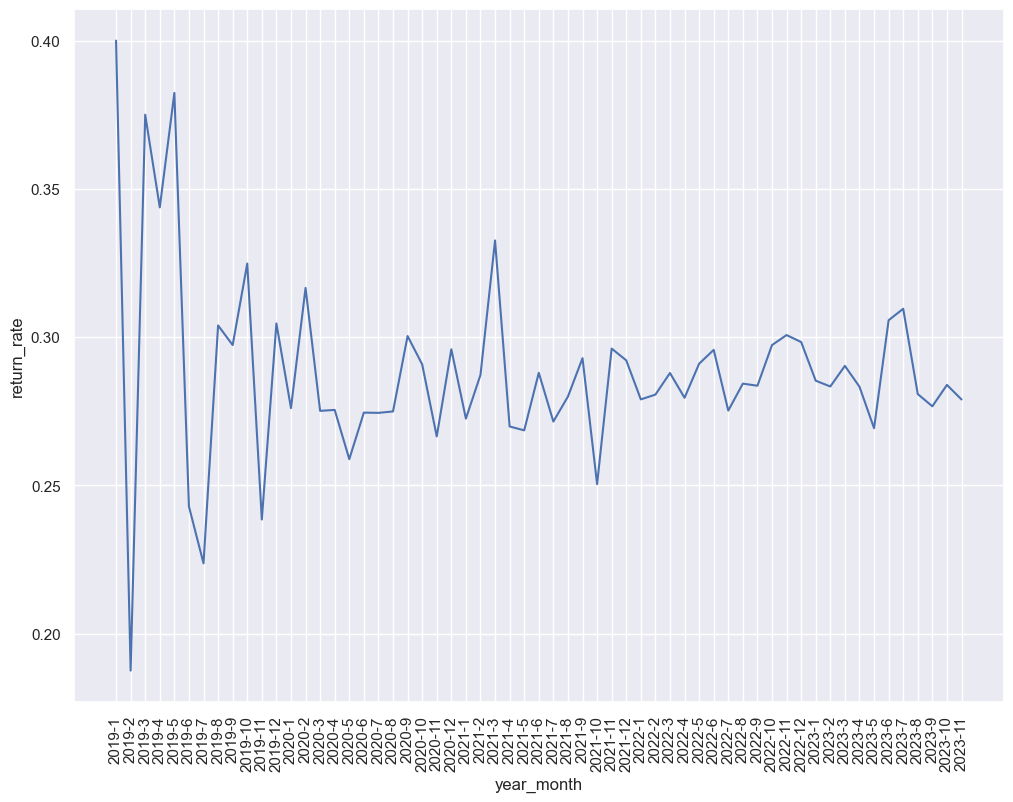

In [322]:
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
fig, axes = plt.subplots(figsize=(12, 9))
sns.lineplot(x="year_month", y="return_rate",data=return_rate_by_month)

plt.xticks(rotation=90)
